Dans ce IPYNB, nous travaillerons avec l'énergie totale ou son log au lieu de l'énergie au m2

# Packages

In [1]:
import numpy as np   
import pandas as pd
import math
import sklearn
import plotly_express as px
import plotly.graph_objects as go
import matplotlib.pyplot as plt
from plotly.offline import plot
from plotly.subplots import make_subplots
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor, HistGradientBoostingRegressor
from sklearn.linear_model import LinearRegression, SGDRegressor, HuberRegressor
from sklearn.svm import SVR
from sklearn.decomposition import PCA
from sklearn.metrics import mean_absolute_error,r2_score,mean_squared_error
from sklearn.pipeline import make_pipeline,Pipeline
from sklearn.preprocessing import StandardScaler,OneHotEncoder
from sklearn.compose import ColumnTransformer
from pandas.api.types import CategoricalDtype
import seaborn as sns
from matplotlib.patches import Patch  # for custom legend - square patches
from matplotlib.lines import Line2D
from matplotlib.ticker import FuncFormatter
import statsmodels.api as sm
import xgboost as xgb
import lightgbm as lgb
from statsmodels.graphics.api import abline_plot
import tensorflow as tf
from tensorflow import keras
import shap
import optuna
#from linearmodels import PanelOLS
#from linearmodels.panel import Panel
from sklearn.ensemble import StackingRegressor


# Imports

In [ ]:
data_college = pd.read_excel("path/data_college_cd53.xlsx",sheet_name="Feuil1")
liaison_ref_conso = pd.read_excel("path/data_college_cd53.xlsx",sheet_name="Table Cor",header=2)
college_conso = pd.read_excel("path/Data_source/Requete_Collèges_31-01-2024.xlsx",sheet_name="Résultat",header=3)

Méthode simplifiée<br>
Si le calcul ne doit pas faire l’objet d’une réglementation, une méthode simplifiée est accessible :

On divisera la consommation de chaque bâtiment par sa surface chauffée, exprimée en m². Le ratio en kWh/m² le plus élevé sera l’indice du bâtiment le plus “mauvais” sur le plan énergétique. Au passage, on pourra alors déjà se comparer aux consommations du secteur.<br>
Il se peut que le plus mauvais bâtiment… soit très petit, et que donc le potentiel d’économie d’énergie soit faible. Il sera alors plus opportun d’attaquer d’abord un bâtiment d’un peu meilleure qualité, mais dont la consommation importante amortira beaucoup mieux les investissements (un appareil de régulation représente le même investissement dans un petit bâtiment que dans un grand). Dans ce but, on multiplie le ratio trouvé précédemment par la consommation du bâtiment. On fait donc (consommation /surface chauffée) x consommation, exprimé en [kWh²/m²]. Le plus grand nombre trouvé est sans signification, mais c’est celui dont le potentiel d’économie d’énergie est le plus grand.

source: https://energieplus-lesite.be/gerer/energie-et-consommations/Etablir-la-comptabilite-energetique/classement-energetique-de-plusieurs-batiments-cadastre-energetique/

# Traitement de données

### Jointure

In [3]:
data_intermediaire = data_college.merge(liaison_ref_conso,left_on="Nom_etablissement",right_on="Ref")

In [4]:
test = data_intermediaire.merge(college_conso,left_on="Consommation",right_on="Nom")

In [5]:
colonnes_a_supp = ['Nom', 'Adresse','Ref', 'Annexe_bat',
       'Effectifs', 'Capacite_accueil_y', 'Chambres_froides',
       'Système_de_regul', 'Consommation', 'Surface_plancher',
       'Suivi régulier de la facture énergétique']

In [6]:
test = test.drop(columns=colonnes_a_supp)
test = test.rename(columns={'Adresse_1':"Adresse",
                            'Mois':'Mois_nom',
                            "Capacite_accueil_x":"Capacite_accueil"})
                            

Données avec les bons nombre d'élèves de 2018 à 2021

In [ ]:
test = pd.read_excel("path/data_college_cd53.xlsx",sheet_name="Feuil3",header=2)

### Suppression de Fernand Puech

In [8]:
test = test.loc[test["Nom_etablissement"]!= "Collège FERNAND PUECH" ]

In [9]:
test["Realisation_audit_energetique"] = test["Année de réalisation d'un audit énergétique"].apply(lambda x: "non" if pd.isna(x) else "oui")

### Création variable pour si y a eu une 2nde construction ou non

In [10]:
renov=[]
for i in range(len(test)):
    if test['Année de construction la plus ancienne'].iloc[i]==test['Année de construction la plus récente'].iloc[i]:
        renov+=[0]
    else:
        renov+=[1]

test["Renovation"] = renov

test = test.drop(columns=['Année de construction la plus ancienne','Année de construction la plus récente'])

### Choix de la puissance de chaudière max (pour certains cas)

In [11]:
l = []
control_list=[]
s = list(test["Puissange_total_chaudiere"])
for i in range(len(s)):
    num = str(s[i]).split(" ")[0].split("K")[0] ## Sélectionne la valeur sans unité
    control_list += [num]
for puissance in control_list: ## boucle pour traiter les puissances données comme: 100/300
    if len(str(puissance).split("/"))==2:
        num = puissance.split("/")[1] ## ou .split("/")[0] pour prendre la valeur min
    else:
        num = puissance.split("/")[0]    
    l+=[float(num)]

test["Puissange_total_chaudiere"] = l


### Suppression des énergies négatives

In [12]:
test[['Nombre_chaudiere', 'Puissange_total_chaudiere',
       'Energie Finale Fact - Gaz propane (kWhEF Fact)',
       'Energie Finale Fact - Gaz naturel (kWhEF Fact)',
       'Energie Finale Fact - Fioul domestique (kWhEF Fact)',
       'Energie Finale Fact - Chauffage urbain (kWhEF Fact)',
       'Energie Finale Fact - Bois plaquettes forestières (kWhEF Fact)',
       'Energie Finale Fact - Electrique (kWhEF Fact)', 'Consommation - Eau',
       'Coût TTC - Gaz propane (€ TTC)', 'Coût TTC - Gaz naturel (€ TTC)',
       'Coût TTC - Fioul domestique (€ TTC)',
       'Coût TTC - Chauffage urbain (€ TTC)',
       'Coût TTC - Bois plaquettes forestières (€ TTC)',
       'Coût TTC - Electrique (€ TTC)', 'Coût TTC - Eau (€ TTC)']] = test[['Nombre_chaudiere', 'Puissange_total_chaudiere',
       'Energie Finale Fact - Gaz propane (kWhEF Fact)',
       'Energie Finale Fact - Gaz naturel (kWhEF Fact)',
       'Energie Finale Fact - Fioul domestique (kWhEF Fact)',
       'Energie Finale Fact - Chauffage urbain (kWhEF Fact)',
       'Energie Finale Fact - Bois plaquettes forestières (kWhEF Fact)',
       'Energie Finale Fact - Electrique (kWhEF Fact)', 'Consommation - Eau',
       'Coût TTC - Gaz propane (€ TTC)', 'Coût TTC - Gaz naturel (€ TTC)',
       'Coût TTC - Fioul domestique (€ TTC)',
       'Coût TTC - Chauffage urbain (€ TTC)',
       'Coût TTC - Bois plaquettes forestières (€ TTC)',
       'Coût TTC - Electrique (€ TTC)', 'Coût TTC - Eau (€ TTC)']].fillna(0)
       
test = test.loc[test['Energie Finale Fact - Gaz naturel (kWhEF Fact)']>=0].loc[test['Energie Finale Fact - Chauffage urbain (kWhEF Fact)']>=0] #suppression des énergies négatives

In [13]:
# Divise par 1 millions pour convertir en tonnes
test["Emission_CO2"] = (100*test["Energie Finale Fact - Chauffage urbain (kWhEF Fact)"] + 30*test["Energie Finale Fact - Bois plaquettes forestières (kWhEF Fact)"] + 227*(test["Energie Finale Fact - Gaz naturel (kWhEF Fact)"]+ 324*(1-0.2)*test["Energie Finale Fact - Gaz propane (kWhEF Fact)"]) + 324*test["Energie Finale Fact - Fioul domestique (kWhEF Fact)"] + 61*test["Energie Finale Fact - Electrique (kWhEF Fact)"]) / 1000000
emission_colleges_totale_2021 = test.loc[test["Année"]==2021]["Emission_CO2"].sum()

print(f"Les collèges ont émis: {np.round(emission_colleges_totale_2021 / 125661.39 * 100,2)} % des émissions du secteur teriaire en 2021.")

emission_tot_par_m2_2021 = test.loc[test["Année"]==2021]["Emission_CO2"].sum() / test.loc[test["Année"]==2021]["Surface terrain (m²)"].sum()
print(f"L'ensemble des collèges a émis: {emission_tot_par_m2_2021 * 1000} Kg de CO2/m2 en 2021.")


Les collèges ont émis: 18.46 % des émissions du secteur teriaire en 2021.
L'ensemble des collèges a émis: 4.935089446358756 Kg de CO2/m2 en 2021.


### Ramener les conso au mètre carré

In [14]:
test["Energie_totale"] = test['Energie Finale Fact - Gaz propane (kWhEF Fact)'] + test ['Energie Finale Fact - Fioul domestique (kWhEF Fact)'] + test['Energie Finale Fact - Gaz naturel (kWhEF Fact)'] + test['Energie Finale Fact - Chauffage urbain (kWhEF Fact)'] + test['Energie Finale Fact - Bois plaquettes forestières (kWhEF Fact)'] + test['Energie Finale Fact - Electrique (kWhEF Fact)']


#liste_annees = list(test["Année"].unique())
#for i in range(len(liste_annees)):
#    donnees_graphe = test.loc[test["Année"]==liste_annees[i]][['Nom_etablissement','Energie_totale']].loc[test['Nom_etablissement']=="Collège de Misedon"].groupby(by="Nom_etablissement",as_index=True).sum()
#    print(f"Pour l'année {liste_annees[i]}, la conso de MISEDON est de: {np.round(donnees_graphe['Energie_totale'])}")

In [15]:
# for col in ['Puissange_total_chaudiere',
#        'Energie Finale Fact - Gaz propane (kWhEF Fact)',
#        'Energie Finale Fact - Gaz naturel (kWhEF Fact)',
#        'Energie Finale Fact - Fioul domestique (kWhEF Fact)',
#        'Energie Finale Fact - Chauffage urbain (kWhEF Fact)',
#        'Energie Finale Fact - Bois plaquettes forestières (kWhEF Fact)',
#        'Energie Finale Fact - Electrique (kWhEF Fact)', 'Consommation - Eau']: # , 'Consommation - Eau' a enlever si moins de 3 modèles ont accuracy de plus de 70%
   
#     test[col] = test[col] / test['Surface plancher (m²)']

### Calcul de l'énergie totale

In [16]:
test["Energie_totale"] = test['Energie Finale Fact - Gaz propane (kWhEF Fact)'] + test ['Energie Finale Fact - Fioul domestique (kWhEF Fact)'] + test['Energie Finale Fact - Gaz naturel (kWhEF Fact)'] + test['Energie Finale Fact - Chauffage urbain (kWhEF Fact)'] + test['Energie Finale Fact - Bois plaquettes forestières (kWhEF Fact)'] + test['Energie Finale Fact - Electrique (kWhEF Fact)']
test["Depenses_totales"] = test['Coût TTC - Gaz propane (€ TTC)'] + test ['Coût TTC - Fioul domestique (€ TTC)'] + test['Coût TTC - Bois plaquettes forestières (€ TTC)'] + test['Coût TTC - Electrique (€ TTC)']

test = test.loc[(test["Energie_totale"]>12680)]

In [17]:
variables_a_garder = ['Hebergement', 'ULIS','Segpa', 'Section_sport', 'Nombre_d_eleves',
        'annee_ouverture','AccWeb_CableFibreOptique',
        #'Année de construction la plus ancienne',
        'Renovation',
       'Surface terrain (m²)',
       #'Surface plancher (m²)',
       'Nombre de bâtiments', 
       'Surface chauffée', 'Mode de chauffage', 
        'Audit SDIE',
       'Capacite_accueil',
       'Nombre_chaudiere', 'Puissange_total_chaudiere',
       'Type_energie_chaudiere', 'Mois_nom', 'Année',
       'Energie Finale Fact - Gaz propane (kWhEF Fact)',
       'Energie Finale Fact - Gaz naturel (kWhEF Fact)',
       'Energie Finale Fact - Fioul domestique (kWhEF Fact)',
       'Energie Finale Fact - Chauffage urbain (kWhEF Fact)',
       'Energie Finale Fact - Bois plaquettes forestières (kWhEF Fact)',
       'Energie Finale Fact - Electrique (kWhEF Fact)']#, 'Consommation - Eau']

variables_num = [  'Nombre_d_eleves',
        'annee_ouverture',
        #'Année de construction la plus ancienne',
        'Renovation',
       'Surface terrain (m²)',
       'Nombre de bâtiments', 
       'Surface plancher (m²)', 'Surface chauffée', 
       'Capacite_accueil', 
       'Nombre_chaudiere', 'Puissange_total_chaudiere',
       'Energie Finale Fact - Gaz propane (kWhEF Fact)',
       'Energie Finale Fact - Gaz naturel (kWhEF Fact)',
       'Energie Finale Fact - Fioul domestique (kWhEF Fact)',
       'Energie Finale Fact - Chauffage urbain (kWhEF Fact)',
       'Energie Finale Fact - Bois plaquettes forestières (kWhEF Fact)',
       'Energie Finale Fact - Electrique (kWhEF Fact)']#, 'Consommation - Eau']

variables_cat = ['Hebergement', 'ULIS', 'Segpa', 'Section_sport', 
       'AccWeb_CableFibreOptique', 'Mode de chauffage',
        'Audit SDIE', 'Type_energie_chaudiere', 'Mois_nom']

### Catégorisation des données

In [18]:
category_non_oui = pd.CategoricalDtype(categories=['non', 'oui'], ordered=True) # AccWeb_CableFibreOptique

category_non_oui_maj = pd.CategoricalDtype(categories=['NON', 'OUI'], ordered=True) # 'Audit SDIE'

category_type_nrj_chaudiere = pd.CategoricalDtype(categories=['Fuel', 'Gaz', 'Gaz propane', 'Electrique'], ordered=True) # Type_energie_chaudiere

category_mode_chauffage = pd.CategoricalDtype(categories=['FOD', 'GN', 'GP', 'FOD+BOIS', 'GN+RC', 'GP+RC', 'ELECTRICITE'], ordered=True) # Mode de chauffage

category = pd.CategoricalDtype(categories=[0, 1], ordered=True)

category_mois = pd.CategoricalDtype(categories=['Janvier','Février','Mars','Avril','Mai','Juin','Juillet','Aout',
 'Septembre','Octobre','Novembre','Décembre'], ordered=True) # Mois

In [19]:
test = test.astype({
    # "AccWeb_CableFibreOptique":category_non_oui,
    # 'Audit SDIE':category_non_oui_maj,
    # "Type_energie_chaudiere":category_type_nrj_chaudiere,
    # 'Restauration':category,
    # 'Mode de chauffage': category_mode_chauffage
    'Hebergement':category
    , 'ULIS':category
    , 'Apprentissage':category
    , 'Segpa':category
    , 'Section_sport':category,
    "Nombre_d_eleves":"int64",
    'Nombre de bâtiments':"int64",
    "annee_ouverture": "int64",
    #'Année de construction la plus ancienne': "int64",
    #'Année de construction la plus récente': "int64",
    'Nombre de bâtiments': "int64" ,
    "Capacite_accueil": "int64" ,
    "Année": "int64",
    # "Mois_nom": category_mois,
    #"Année de réalisation d'un audit énergétique":"int64",
    'Nombre_chaudiere':"int64"
})

### Calcul des émissions de CO2(en tonnes/m2)

lien pour le calcul des émissions pour le propane: https://www.francegazliquides.fr/energie-butane-propane/industrie-et-distribution/lenergie-propane-reseaux/<br>
"Le propane émet 20% de CO2 de moins que le fioul" <br>

lien pur le calcul des émissions pour l'électricité: https://app.electricitymaps.com/zone/FR<br>
"intensité de carbone = 61g/kWh en France en 2021."<br>

lien pour le calcul des émissions des autres sources d'énergie: https://www.economiedenergie.fr/les-emissions-de-co2-par-energie/ <br>
utilise la table de correspondance "Les émissions des énergies pour la production d’électricité en équivalent CO2 (CO2e) en gramme par kilowattheure d’énergie finale" <br>

(2021 est l'année de la dernière mise à jour des données ADEME)

(peut utiliser electricity map, mais la valeur de l'intensité carbone change au fil du temps)

In [20]:
# Divise par 1 millions pour convertir en tonnes
test["Emission_CO2_au_m_carre"] = (100*test["Energie Finale Fact - Chauffage urbain (kWhEF Fact)"] + 24*test["Energie Finale Fact - Bois plaquettes forestières (kWhEF Fact)"] + 227*(test["Energie Finale Fact - Gaz naturel (kWhEF Fact)"]+ 324*(1-0.2)*test["Energie Finale Fact - Gaz propane (kWhEF Fact)"]) + 324*test["Energie Finale Fact - Fioul domestique (kWhEF Fact)"] + 64*test["Energie Finale Fact - Electrique (kWhEF Fact)"]) / 1000000


# Correlation

In [21]:
test_donnees_corr= test[variables_num+['Energie_totale']]

correlation_matrix = test_donnees_corr.corr()
relevant_features = correlation_matrix['Energie Finale Fact - Electrique (kWhEF Fact)'].abs().sort_values(ascending=False).index[1:]
correlation_matrix

,Nombre_d_eleves,annee_ouverture,Renovation,Surface terrain (m²),Nombre de bâtiments,Surface plancher (m²),Surface chauffée,Capacite_accueil,Nombre_chaudiere,Puissange_total_chaudiere,Energie Finale Fact - Gaz propane (kWhEF Fact),Energie Finale Fact - Gaz naturel (kWhEF Fact),Energie Finale Fact - Fioul domestique (kWhEF Fact),Energie Finale Fact - Chauffage urbain (kWhEF Fact),Energie Finale Fact - Bois plaquettes forestières (kWhEF Fact),Energie Finale Fact - Electrique (kWhEF Fact),Energie_totale
Nombre_d_eleves,1.000000,-0.033331,0.613537,0.392875,0.056560,0.790190,0.830929,0.803337,-0.041085,0.030296,-0.237104,0.279533,-0.213678,0.140015,0.014540,0.612862,0.388178
annee_ouverture,-0.033331,1.000000,-0.175950,-0.167812,-0.377111,-0.133084,-0.141952,-0.079201,-0.148398,-0.263800,-0.228680,0.083921,-0.146428,-0.015260,-0.170240,-0.099803,-0.041161
Renovation,0.613537,-0.175950,1.000000,0.396779,0.087284,0.644432,0.630986,0.660867,-0.079002,-0.155399,-0.171857,0.090431,-0.152965,0.230678,0.291515,0.312039,0.270189
Surface terrain (m²),0.392875,-0.167812,0.396779,1.000000,0.318686,0.427512,0.485650,0.523856,0.005124,-0.083386,-0.227923,0.152553,-0.202315,0.166716,-0.053091,0.193304,0.189213
Nombre de bâtiments,0.056560,-0.377111,0.087284,0.318686,1.000000,0.147624,0.207177,0.057818,-0.120267,0.359008,-0.076404,0.089559,-0.222746,0.103266,-0.003608,0.182144,0.112135
Surface plancher (m²),0.790190,-0.133084,0.644432,0.427512,0.147624,1.000000,0.979200,0.869832,-0.094299,0.098572,-0.361721,0.409798,-0.307531,0.199277,-0.035245,0.613783,0.501678
Surface chauffée,0.830929,-0.141952,0.630986,0.485650,0.207177,0.979200,1.000000,0.880803,-0.083807,0.116918,-0.361350,0.394914,-0.319527,0.233034,-0.042597,0.627178,0.503301
Capacite_accueil,0.803337,-0.079201,0.660867,0.523856,0.057818,0.869832,0.880803,1.000000,-0.034136,0.253412,-0.400453,0.286007,-0.339508,0.331142,0.026609,0.457976,0.420436
Nombre_chaudiere,-0.041085,-0.148398,-0.079002,0.005124,-0.120267,-0.094299,-0.083807,-0.034136,1.000000,0.111957,0.384907,-0.103420,0.080202,0.095896,-0.090050,-0.229672,-0.044307
Puissange_total_chaudiere,0.030296,-0.263800,-0.155399,-0.083386,0.359008,0.098572,0.116918,0.253412,0.111957,1.000000,-0.159621,0.048848,-0.120351,0.159330,-0.014248,-0.025174,0.078034


In [22]:
variables_a_garder = ['Hebergement', 'ULIS','Segpa', 'Section_sport', 'Nombre_d_eleves',
        'annee_ouverture',
        'AccWeb_CableFibreOptique',
        'Renovation',
       'Surface terrain (m²)',
       #'Surface plancher (m²)',
       'Nombre de bâtiments', 
       'Surface chauffée', 
       'Mode de chauffage',
       "Realisation_audit_energetique", 
        'Audit SDIE',
       'Capacite_accueil',
       'Nombre_chaudiere', 
       'Puissange_total_chaudiere',
       'Type_energie_chaudiere', 'Mois_nom', 'Année',
       'Energie Finale Fact - Gaz propane (kWhEF Fact)',
       'Energie Finale Fact - Gaz naturel (kWhEF Fact)',
       'Energie Finale Fact - Fioul domestique (kWhEF Fact)',
       'Energie Finale Fact - Chauffage urbain (kWhEF Fact)',
       'Energie Finale Fact - Bois plaquettes forestières (kWhEF Fact)',
       'Energie Finale Fact - Electrique (kWhEF Fact)']#, 'Consommation - Eau']

# Graphique

In [23]:
#test[["Nom_etablissement",'Energie Finale Fact - Chauffage urbain (kWhEF Fact)']].groupby(by="Nom_etablissement",as_index=False).sum()


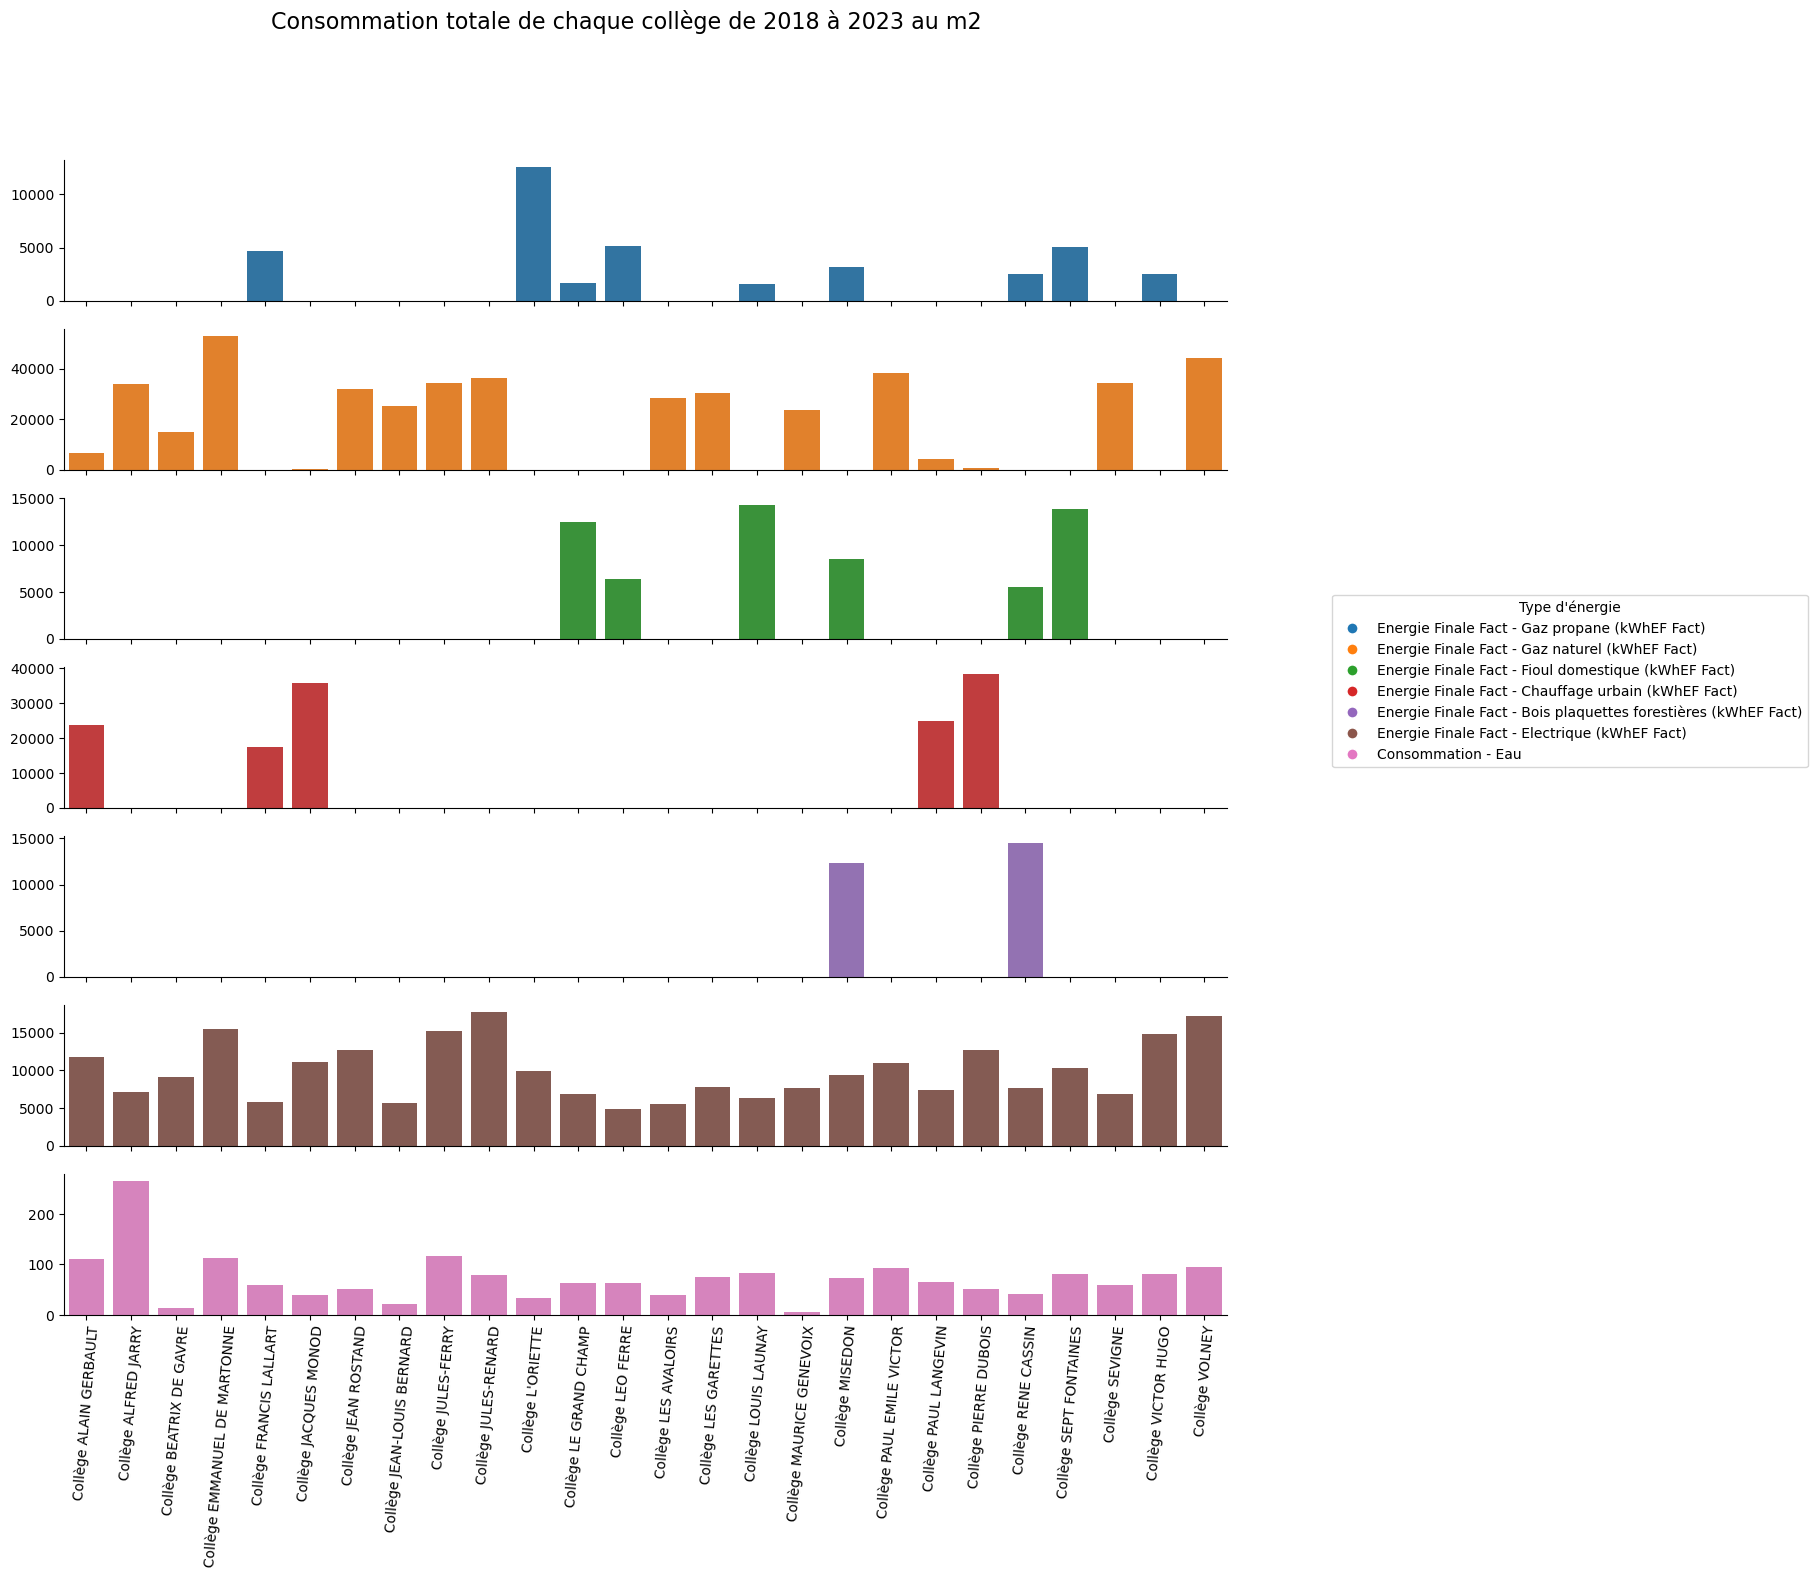

In [24]:
df_dict = dict()
liste_conso = ['Energie Finale Fact - Gaz propane (kWhEF Fact)',
       'Energie Finale Fact - Gaz naturel (kWhEF Fact)',
       'Energie Finale Fact - Fioul domestique (kWhEF Fact)',
       'Energie Finale Fact - Chauffage urbain (kWhEF Fact)',
       'Energie Finale Fact - Bois plaquettes forestières (kWhEF Fact)',
       'Energie Finale Fact - Electrique (kWhEF Fact)','Consommation - Eau']

colors = sns.color_palette('tab10', n_colors=len(liste_conso))  # get a number of colors
cmap = dict(zip(liste_conso, colors))


fig,axes = plt.subplots(nrows=7, ncols=1, figsize=(15, 15),sharex=True)
fig.suptitle("Consommation totale de chaque collège de 2018 à 2023 au m2",fontsize=16)
axes = axes.flat

for col in liste_conso:
    donnees_graphe = test[["Nom_etablissement",col]].groupby(by=["Nom_etablissement"],as_index=False,).mean()
    df_dict[col] = pd.DataFrame(donnees_graphe)
    
    

for ax, (k, v) in zip(axes, df_dict.items()):
    
    graph=sns.barplot(data=v, x='Nom_etablissement', y=k, ax=ax,color=cmap.get(k,"black"))
    graph.set(ylabel=None,xlabel=None)
    for item in graph.get_xticklabels():
        item.set_rotation(85)
    sns.despine(top=True, right=True)


patches = [Line2D([0], [0], marker='o', color='w', markerfacecolor=v, label=k, markersize=8) for k, v in cmap.items()]  # round markers

# place legend outside of plot; change the right bbox value to move the legend up or down
plt.legend(title="Type d'énergie", handles=patches, bbox_to_anchor=(1.5, 4.5), loc='center right', borderaxespad=0)
plt.show()


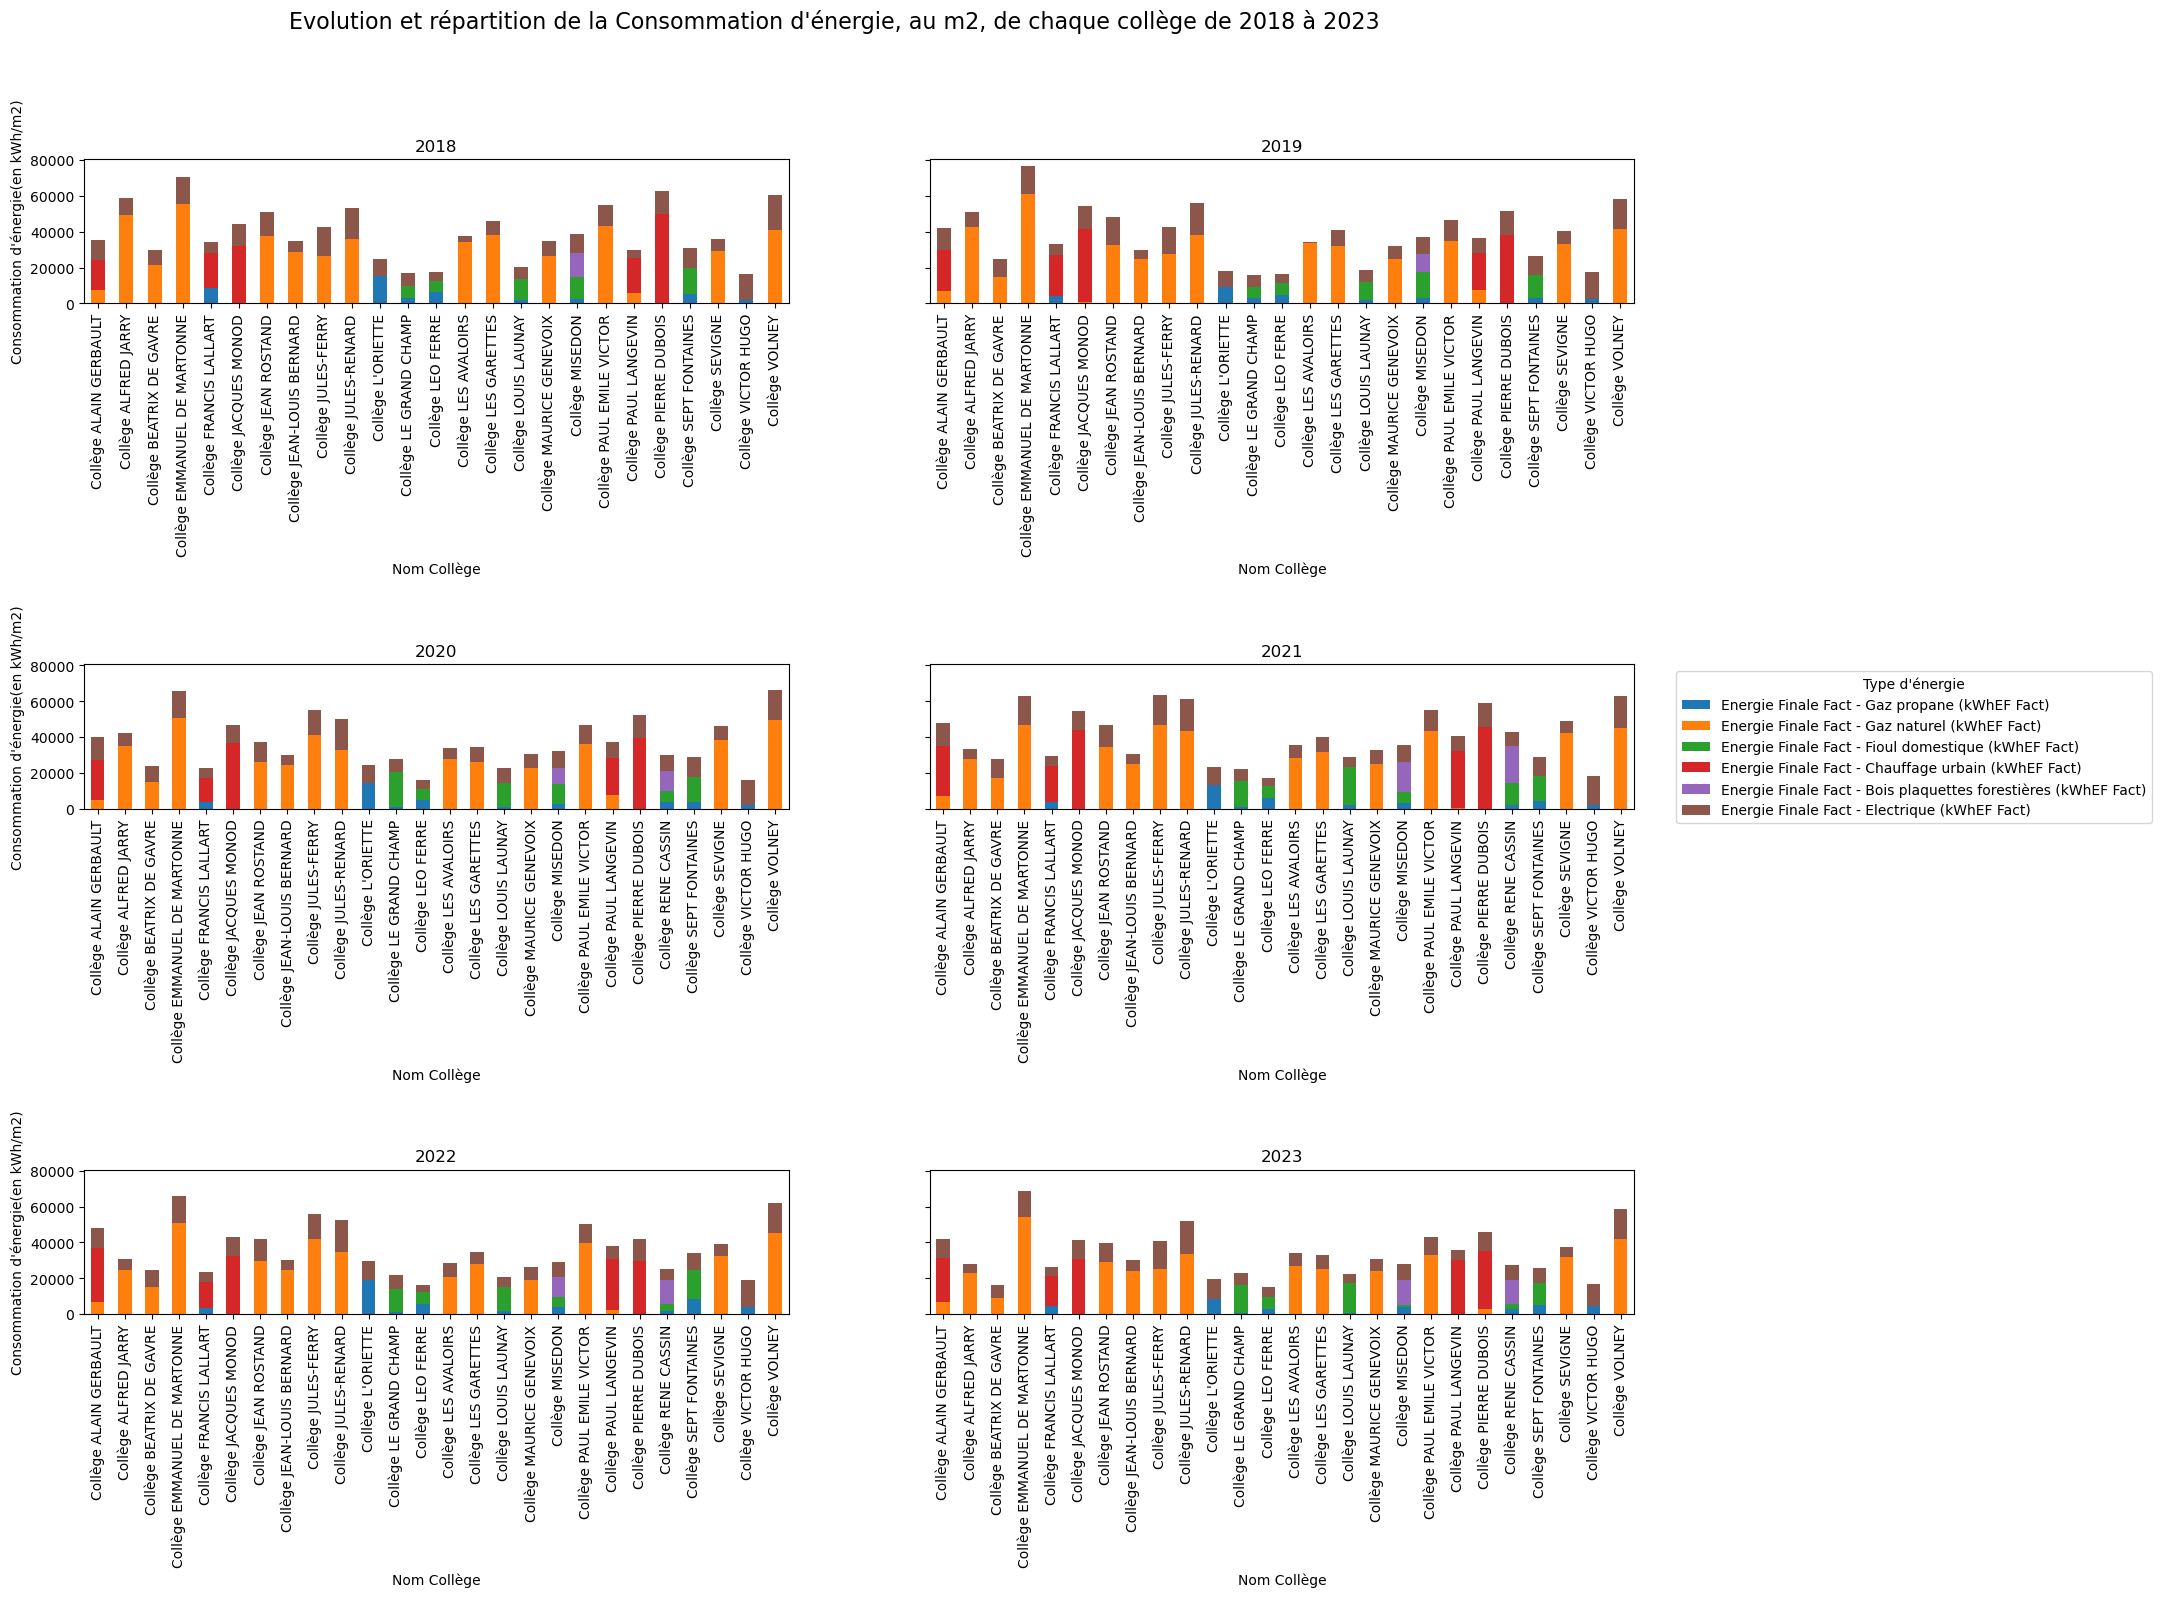

In [25]:
#liste_conso = liste_conso.append("Nom_etablissement")
liste_conso = ['Nom_etablissement','Energie Finale Fact - Gaz propane (kWhEF Fact)',
       'Energie Finale Fact - Gaz naturel (kWhEF Fact)',
       'Energie Finale Fact - Fioul domestique (kWhEF Fact)',
       'Energie Finale Fact - Chauffage urbain (kWhEF Fact)',
       'Energie Finale Fact - Bois plaquettes forestières (kWhEF Fact)',
       'Energie Finale Fact - Electrique (kWhEF Fact)']

liste_annees = list(test["Année"].unique())

fig,axes = plt.subplots(nrows=3, ncols=2, figsize=(40, 25),sharey=True,sharex=False)
fig.suptitle("Evolution et répartition de la Consommation d'énergie, au m2, de chaque collège de 2018 à 2023",fontsize=16)
axes = axes.flat

for i in range(len(liste_annees)):
       donnees_graphe = test.loc[test["Année"]==liste_annees[i]][liste_conso].groupby(by="Nom_etablissement",as_index=True).mean()
       #donnees_graphe = donnees_graphe.loc[donnees_graphe.sum(axis=1).sort_values(ascending=False).index]
       #donnees_graphe = pd.DataFrame(donnees_graphe.set_index("Nom_etablissement", inplace=True))

       # Plotting the stacked barplot
       donnees_graphe.plot(kind='bar', stacked=True, figsize=(20, 15),color=cmap,rot=90,ax=axes[i],legend=False)

       # Adding labels and title
       #plt.xlabel('Nom Collège')
       #plt.ylabel('Conso énegétique (en kWh)')
       axes[i].set_xlabel(f'Nom Collège')
       axes[i].set_ylabel(f"Consommation d'énergie(en kWh/m2)")
       axes[i].set_title(f'{liste_annees[i]}')

       # Set custom Y-axis labels to display values in millions
       #formatter = FuncFormatter(lambda x, _: f'{int(x/1e6)} M')
       #graph.yaxis.set_major_formatter(formatter)

# Display the legend
plt.legend(title="Type d'énergie", bbox_to_anchor=(1.05, 4.5), loc='upper left')
plt.subplots_adjust(hspace=2.5)

# Show the plot
plt.show()

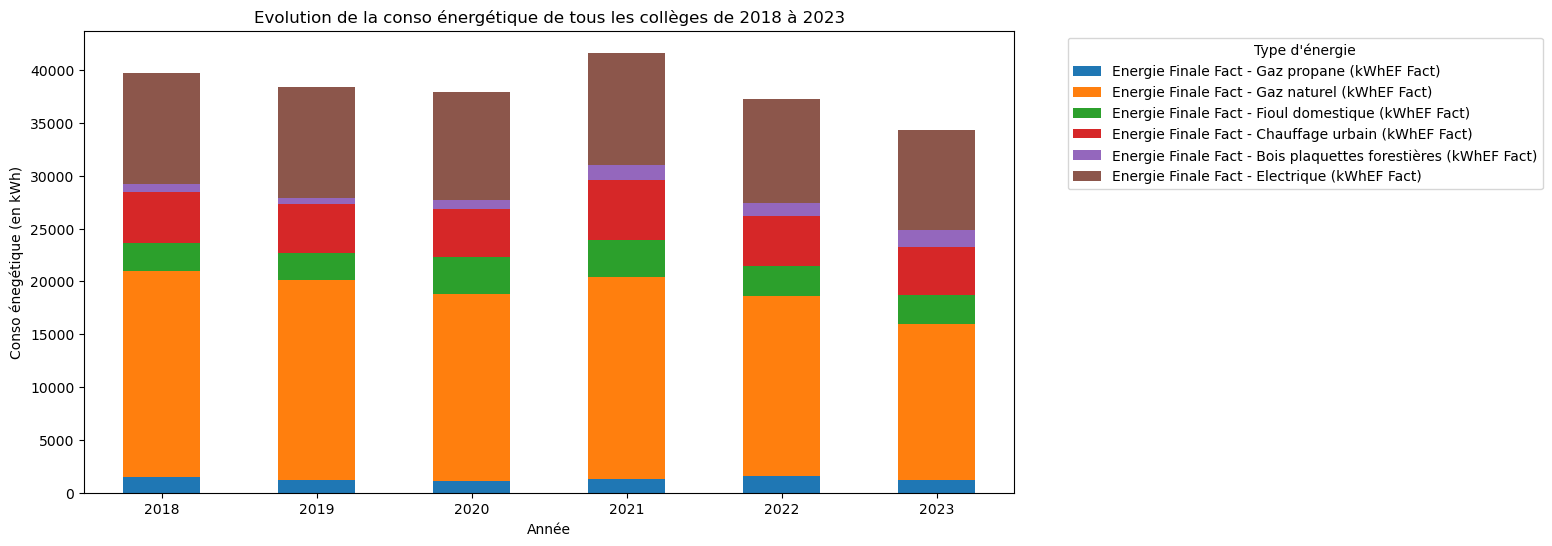

In [26]:
liste_conso = ['Année','Energie Finale Fact - Gaz propane (kWhEF Fact)',
       'Energie Finale Fact - Gaz naturel (kWhEF Fact)',
       'Energie Finale Fact - Fioul domestique (kWhEF Fact)',
       'Energie Finale Fact - Chauffage urbain (kWhEF Fact)',
       'Energie Finale Fact - Bois plaquettes forestières (kWhEF Fact)',
       'Energie Finale Fact - Electrique (kWhEF Fact)']

donnees_graphe = test[liste_conso].groupby(by=["Année"],as_index=True).mean()
#donnees_graphe = donnees_graphe.loc[donnees_graphe.sum(axis=1).sort_values(ascending=False).index]
#donnees_graphe = pd.DataFrame(data.set_index("Nom_etablissement", inplace=True))

       # Plotting the stacked barplot
graph = donnees_graphe.plot(kind='bar', stacked=True, figsize=(12, 6),color=cmap,rot=0)

# Adding labels and title
plt.xlabel('Année')
plt.ylabel('Conso énegétique (en kWh)')
plt.title('Evolution de la conso énergétique de tous les collèges de 2018 à 2023')

       # Set custom Y-axis labels to display values in millions
#formatter = FuncFormatter(lambda x, _: f'{int(x/1e6)} M')
#graph.yaxis.set_major_formatter(formatter)

# Display the legend
plt.legend(title="Type d'énergie", bbox_to_anchor=(1.05, 1), loc='upper left')

# Show the plot
plt.show()

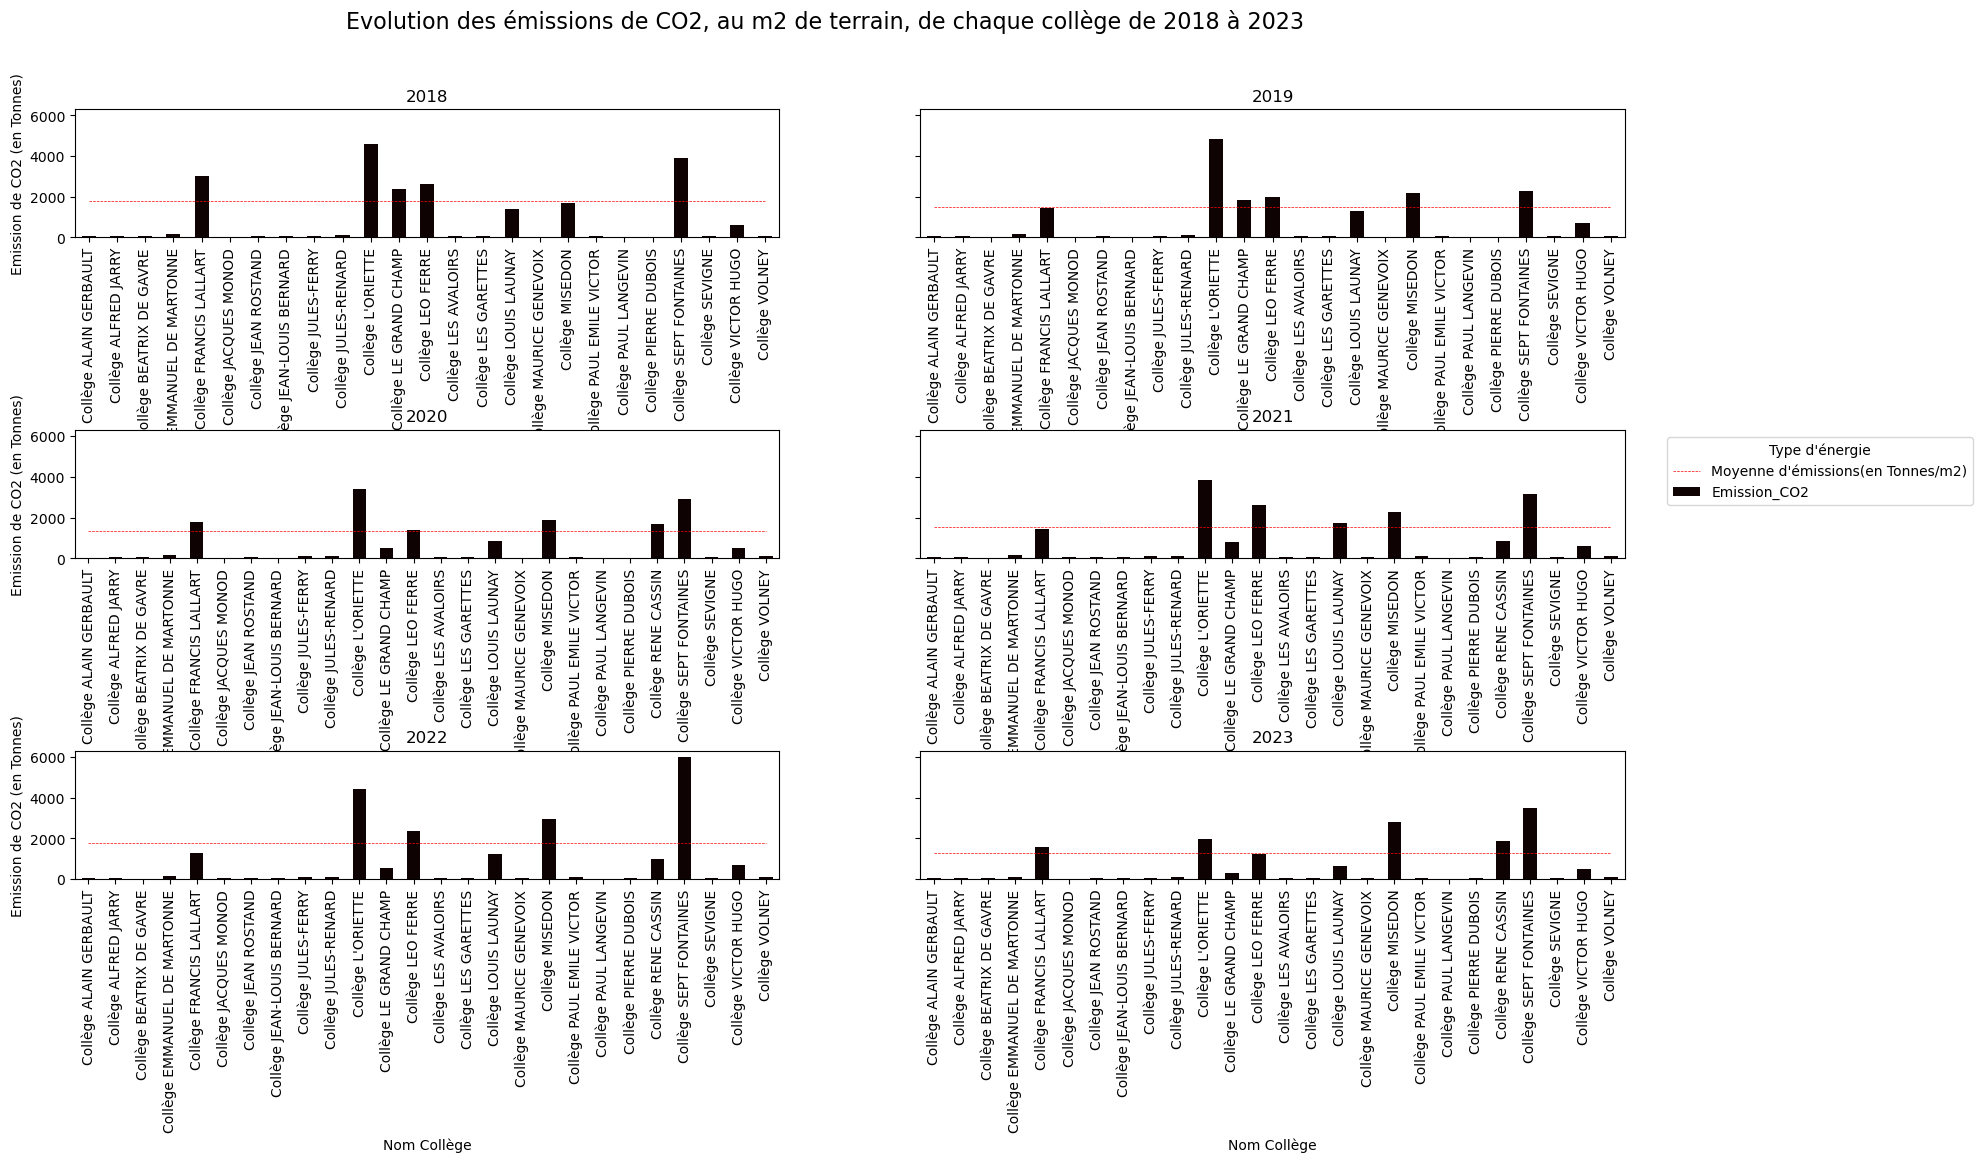

In [27]:
liste_conso = ['Nom_etablissement','Emission_CO2']

liste_annees = list(test["Année"].unique())

fig,axes = plt.subplots(nrows=3, ncols=2, figsize=(40, 25),sharey=True,sharex=False)
fig.suptitle("Evolution des émissions de CO2, au m2 de terrain, de chaque collège de 2018 à 2023",fontsize=16)
axes = axes.flat

for i in range(len(liste_annees)):
       donnees_graphe = test.loc[test["Année"]==liste_annees[i]][liste_conso].groupby(by="Nom_etablissement",as_index=True).sum()

       # Plotting the stacked barplot
       donnees_graphe.plot(kind='bar', stacked=True, figsize=(20, 10),rot=90,ax=axes[i],legend=False,color="#0f0202")
       
       moyenne = test.loc[test["Année"]==liste_annees[i]]["Emission_CO2"].sum()/12 ## divise par 12 car il y a 12 mois dans l'année
       axes[i].plot(donnees_graphe.index, np.full(len(donnees_graphe),moyenne),  color='red', linestyle='--', linewidth=0.5, label="Moyenne d'émissions(en Tonnes/m2)")
       
       axes[i].set_xlabel('Nom Collège')
       axes[i].set_ylabel('Emission de CO2 (en Tonnes)')
       axes[i].set_title(f'{liste_annees[i]}')

       # Set custom Y-axis labels to display values in millions
       #formatter = FuncFormatter(lambda x, _: f'{int(x/1e6)} M')
       #graph.yaxis.set_major_formatter(formatter)

# Display the legend
plt.legend(title="Type d'énergie", bbox_to_anchor=(1.05, 3.5), loc='upper left')
plt.subplots_adjust(hspace=1.5)

# Show the plot
plt.show()

# Cartographie

In [28]:
# conso_2023 = test[["Nom_etablissement","Année","Energie_totale"]]
# conso_2023 = conso_2023.loc[conso_2023["Année"]==2023].groupby(by="Nom_etablissement",as_index=False).mean()

In [29]:
# data_carte = pd.DataFrame({
#     "Nom_etablissement": test["Nom_etablissement"],
#     "latitude": test["latitude"],
#     "longitude": test["longitude"],
#     "Adresse": test["Adresse"],
#     'Code postal': test['Code postal'],
#     'Nom_commune': test['Nom_commune']
# })

# data_carte = data_carte.merge(conso_2023,on="Nom_etablissement").drop(columns=["Année"])

In [30]:
# import folium
# map_osm = folium.Map(location=[48.0833, -0.6667])

# for ind, lat, lon, college, adresse, bp,commune,conso in data_carte[['latitude', 'longitude', 'Nom_etablissement',"Adresse",'Code postal','Nom_commune','Energie_totale']].itertuples():
#     html=f"""
#         <h1> {college}</h1>
#         <p>{adresse}, {bp}, {commune}</p>
#         <br\>
#         <strong> Consommation énergétique en 2023: </strong>
#         <h3> {np.round(conso,2)} kWh/m2 </h3>
#         """
#     iframe = folium.IFrame(html=html, width=300, height=190)
#     popup = folium.Popup(iframe, max_width=2650)
#     map_osm.add_child(folium.Marker(location=[lat,lon], popup=popup,
#                        fill_color='#132b5e', radius=15))

# map_osm

# Modélisation

In [31]:
#plt.scatter(test["Consommation - Eau"],np.sqrt(test["Energie_totale"]))

### Création de dummy variables(pour les vars catégorielles)

In [32]:
# test["Lag_conso"] = test.groupby('Nom_etablissement')['Energie_totale'].shift(1)
# test = test.dropna(subset=['Lag_conso'])
# # Réinitialisation de l'index après la suppression des lignes
# test.reset_index(drop=True, inplace=True)

test_donnees_modele = test[variables_a_garder]
test_donnees_modele = test_donnees_modele.drop(['Energie Finale Fact - Gaz propane (kWhEF Fact)',
                                                'Energie Finale Fact - Fioul domestique (kWhEF Fact)',
                                                'Energie Finale Fact - Gaz naturel (kWhEF Fact)',
                                                'Energie Finale Fact - Chauffage urbain (kWhEF Fact)',
                                                'Energie Finale Fact - Bois plaquettes forestières (kWhEF Fact)',
                                                'Energie Finale Fact - Electrique (kWhEF Fact)'], axis=1)

test_donnees_modele["Energie_totale"] = test["Energie_totale"]


# test_donnees_modele['Surface_par_eleve'] = test_donnees_modele['Surface plancher (m²)'] / test_donnees_modele['Nombre_d_eleves']
# test_donnees_modele['Puissance_par_batiment'] = test_donnees_modele['Puissange_total_chaudiere'] / test_donnees_modele['Nombre de bâtiments']
# test_donnees_modele['Chaudiere_par_batiment'] = test_donnees_modele['Nombre_chaudiere'] / test_donnees_modele['Nombre de bâtiments']
# test_donnees_modele['Annee_relative'] = test_donnees_modele['Année'].apply(lambda x: x-2000)
#test_donnees_modele['Taux_occupation'] = test_donnees_modele['Nombre_d_eleves'] / test['Capacite_accueil']

# test_donnees_modele['Année_squared'] = test_donnees_modele['Année'] ** 2
# test_donnees_modele['Lag_conso'] = test["Lag_conso"]
# test_donnees_modele["Nombre_annee_ecoule"] = test_donnees_modele['Année'].apply(lambda x : x-2018)


#test_donnees_modele['Renovation_Type_energie_chaudiere'] = test_donnees_modele['Renovation'].astype(str) + "_" + test_donnees_modele['Type_energie_chaudiere'].astype(str)
#test_donnees_modele['AccWeb_Audit_SDIE'] = test_donnees_modele['AccWeb_CableFibreOptique'].astype(str) + "_" + test_donnees_modele['Audit SDIE'].astype(str)
#test_donnees_modele['winter_month'] = test_donnees_modele['Mois_nom'].apply(lambda x: 'Oui' if x in ['Octobre','Novembre', 'Décembre', 'Janvier', 'Février', 'Mars','Avril'] else 'Non')

# dummy_var = pd.get_dummies(test_donnees_modele[variables_cat])
# dummy_var = dummy_var.astype('int64')

# test_donnees_modele = pd.concat([test_donnees_modele, dummy_var], axis=1)

# # Drop the original categorical column if needed
# test_donnees_modele = test_donnees_modele.drop(variables_cat, axis=1)
#test_donnees_modele = test_donnees_modele.dropna()

Discretisation de consommation eau

In [33]:
min_value = test["Consommation - Eau"].min()
q25 = test["Consommation - Eau"].quantile(0.25)
median = test["Consommation - Eau"].median()
q75 = test["Consommation - Eau"].quantile(0.75)
max_value = test["Consommation - Eau"].max()

quantiles = [min_value, q25, median, q75, max_value]

#test_donnees_modele["Consommation - Eau"] = pd.cut(test_donnees_modele["Consommation - Eau"], bins=quantiles, labels=['Très faible', 'Faible', 'Moyenne', 'Élevée'],include_lowest=True)

In [34]:
new_variables_cat = variables_cat + ["Realisation_audit_energetique"]#+ ["Consommation - Eau"] #+ ['Renovation_Type_energie_chaudiere','winter_month']

var_a_supp = ['Energie Finale Fact - Gaz propane (kWhEF Fact)',
                                                'Energie Finale Fact - Fioul domestique (kWhEF Fact)',
                                                'Energie Finale Fact - Gaz naturel (kWhEF Fact)',
                                                'Energie Finale Fact - Chauffage urbain (kWhEF Fact)',
                                                'Energie Finale Fact - Bois plaquettes forestières (kWhEF Fact)',
                                                'Energie Finale Fact - Electrique (kWhEF Fact)'] + new_variables_cat

new_var_a_garder = variables_a_garder #+ ['Année_squared','Lag_conso',"Nombre_annee_ecoule"] #+ ['Surface_par_eleve','Puissance_par_batiment','Chaudiere_par_batiment','Annee_relative']

preprocessor = ColumnTransformer(
    transformers=[
        ('cat', OneHotEncoder(handle_unknown='ignore'), new_variables_cat),
        ('num', 'passthrough', [item for item in new_var_a_garder if item not in var_a_supp])
    ])

In [35]:
#plt.hist(test_donnees_modele["Consommation - Eau"])

### Suppression des colonnes non utilisées pour les modèles

In [36]:
# test_donnees_modele = test_donnees_modele.drop(['Hebergement_0','ULIS_0',
#                                                 'Segpa_0','Section_sport_0','AccWeb_CableFibreOptique_non', 'Audit SDIE_NON',
#                                                 'Energie Finale Fact - Gaz propane (kWhEF Fact)',
#                                                 'Energie Finale Fact - Fioul domestique (kWhEF Fact)',
#                                                 'Energie Finale Fact - Gaz naturel (kWhEF Fact)',
#                                                 'Energie Finale Fact - Chauffage urbain (kWhEF Fact)',
#                                                 'Energie Finale Fact - Bois plaquettes forestières (kWhEF Fact)',
#                                                 'Energie Finale Fact - Electrique (kWhEF Fact)'], axis=1)



### Séparation en jeu Train et Test

In [37]:
categorical_vars = ['Hebergement','Segpa', 'Section_sport','AccWeb_CableFibreOptique','Mode de chauffage','Realisation_audit_energetique','Type_energie_chaudiere','Audit SDIE']
# Initialiser un DataFrame vide pour les données augmentées

def augmente_donnees(data,categorical_vars):
    df_augmented = data.copy()

    threshold_percent = 0.12

    while True:
        # Calculer le nombre total d'enregistrements dans le DataFrame augmenté actuel
        total_records_augmented = len(df_augmented)
        
        # Calculer le seuil minimal pour chaque modalité afin de représenter 30 % du DataFrame final
        threshold = total_records_augmented * threshold_percent
        
        # Variable de suivi si toutes les modalités atteignent le seuil minimal
        all_modalities_reached_threshold = True
        
        # Sur-échantillonner chaque modalité sous-représentée pour chaque variable catégorielle
        for var in categorical_vars:
            # Calculer la distribution des modalités pour cette variable
            modalities_distribution = df_augmented[var].value_counts(normalize=True)
            
            # Vérifier si chaque modalité atteint le seuil minimal
            if any(modalities_distribution < threshold_percent):
                all_modalities_reached_threshold = False
                
                # Sur-échantillonner les modalités sous-représentées jusqu'à atteindre le seuil minimal
                for modality, distribution in modalities_distribution.items():
                    if distribution < threshold_percent:
                        # Filtrer les enregistrements de cette modalité
                        df_combination = df_augmented[df_augmented[var] == modality]
                        
                        # Calculer le nombre de duplications nécessaires pour atteindre le seuil minimal
                        num_duplications = max(int(threshold / len(df_combination)), 1)
                        
                        # Dupliquer les enregistrements jusqu'à atteindre le seuil minimal
                        df_combination_augmented = pd.concat([df_combination] * num_duplications, ignore_index=True)
                        
                        # Ajouter les enregistrements dupliqués au DataFrame augmenté
                        df_augmented = pd.concat([df_augmented, df_combination_augmented], ignore_index=True)
        
        # Vérifier si toutes les modalités de chaque variable atteignent au moins 30 % du DataFrame augmenté
        if all_modalities_reached_threshold:
            break
    
    return df_augmented


df_augmented = augmente_donnees(test_donnees_modele,categorical_vars)
#df_augmented = test_donnees_modele.copy()
        

In [38]:
#from sklearn.preprocessing import PowerTransformer

#test_donnees_modele['Consommation - Eau'] =  np.sqrt(test_donnees_modele['Consommation - Eau'])
#test_donnees_modele = sm.add_constant(test_donnees_modele)
y = df_augmented["Energie_totale"].apply(lambda x: np.sqrt(x))
#y = y[1:]

#pt = PowerTransformer(method='yeo-johnson')
#y = pt.fit_transform(test[["Energie_totale"]])
#test_donnees_modele['group'] = test_donnees_modele['Surface chauffée'].astype(str) + "_" + test_donnees_modele['Année'].astype(str)

#train_ids, test_ids = train_test_split(df_augmented['Surface chauffée'].unique(), test_size=0.25, random_state=42)

X_train,X_test,y_train,y_test = train_test_split(df_augmented.iloc[:,:-1],y,test_size=0.2,random_state=80)
# X = df_augmented.iloc[:,:-1]
# X_train,X_test,y_train,y_test= X[df_augmented['Année'] < 2022], X[df_augmented['Année'] >= 2022], y[df_augmented['Année'] < 2022], y[df_augmented['Année'] >= 2022]

# df_train_augmented = augmente_donnees(df_augmented[df_augmented['Année'] < 2022], categorical_vars)

# X_train = df_train_augmented.drop(columns=['Energie_totale'])
# y_train = df_train_augmented['Energie_totale'].apply(lambda x: np.sqrt(x))

# X_train = df_augmented[df_augmented['Surface chauffée'].isin(train_ids)]
# y_train = X_train["Energie_totale"].apply(lambda x: np.sqrt(x))
# X_train = X_train.drop(columns=['Energie_totale'])

# X_test = df_augmented[df_augmented['Surface chauffée'].isin(test_ids)]
# y_test = X_test["Energie_totale"].apply(lambda x: np.sqrt(x))
# X_test = X_test.drop(columns=['Energie_totale'])

annual_data_test = pd.concat([X_test, pd.Series(y_test**2,name="Energie_totale")],axis=1)
annual_data_test = annual_data_test[["Année","Energie_totale"]].groupby(by="Année",as_index=False).sum()

annual_data = df_augmented[["Année","Energie_totale"]].groupby(by="Année",as_index=False).sum()

# scaler = StandardScaler()
# X_train_scaled = scaler.fit_transform(X_train)
# X_test_scaled = scaler.transform(X_test)
annual_data_test

,Année,Energie_totale
0,2018,2.402147e+07
1,2019,2.378028e+07
2,2020,2.337021e+07
3,2021,2.816640e+07
4,2022,2.341714e+07
5,2023,2.023878e+07


### Winsorization (Traitement des outliers)

Cellule ci-dessous peut eventuellement aider a améliorer le modèle

In [39]:
q_low = y_test.quantile(0.025)
q_high = y_test.quantile(0.975)

y_test = y_test.clip(lower=q_low, upper=q_high)
y_train = y_train.clip(lower=q_low, upper=q_high)

In [40]:
annual_data_test["Energie_totale"].describe()

count    6.000000e+00
mean     2.383238e+07
std      2.534647e+06
min      2.023878e+07
25%      2.338194e+07
50%      2.359871e+07
75%      2.396117e+07
max      2.816640e+07
Name: Energie_totale, dtype: float64

## Modèles

### GLM

In [41]:
from sklearn.base import BaseEstimator, RegressorMixin

class StatsmodelsGLM(BaseEstimator, RegressorMixin):
    def __init__(self, family=sm.families.Gaussian()):
        self.family = family

    def fit(self, X, y):
        self.model = sm.GLM(y, X, family=self.family).fit()
        return self

    def predict(self, X):
        return self.model.predict(X)
    
    def summary(self):
        return self.model.summary()

In [42]:
modele_glm = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', StatsmodelsGLM())
])
modele_glm.fit(X_train, y_train)
# res = modele_glm.fit()
print(modele_glm['regressor'].summary())

# #MSE
# y_pred = res.predict(X_test)
y_pred = modele_glm.predict(X_test)

annual_data_pred_glm = pd.concat([X_test.reset_index(drop=True), pd.Series(y_pred**2,name="Energie_totale")],axis=1)
annual_data_pred_glm = annual_data_pred_glm[["Année","Energie_totale"]].groupby(by="Année",as_index=False).sum()

mse_glm = mean_squared_error(annual_data_test["Energie_totale"], annual_data_pred_glm["Energie_totale"])
mae_glm = mean_absolute_error(annual_data_test["Energie_totale"], annual_data_pred_glm["Energie_totale"])

## R squared
y_pred_train = modele_glm.predict(X_train)
u = ((y_train-y_pred_train)**2).sum()
v = ((y_train - y_train.mean()) ** 2).sum()
R_squared_glm_train = 1-(u/v)


                 Generalized Linear Model Regression Results                  
Dep. Variable:         Energie_totale   No. Observations:                17573
Model:                            GLM   Df Residuals:                    17538
Model Family:                Gaussian   Df Model:                           34
Link Function:               Identity   Scale:                          766.00
Method:                          IRLS   Log-Likelihood:                -83270.
Date:                Fri, 21 Jun 2024   Deviance:                   1.3434e+07
Time:                        13:51:21   Pearson chi2:                 1.34e+07
No. Iterations:                     3   Pseudo R-squ. (CS):             0.9299
Covariance Type:            nonrobust                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
x1          -803.5623    115.439     -6.961      0.0

In [43]:
#fig = plt.figure(figsize=(12, 8))
#ax = fig.add_subplot(111, ylabel="Observed Values", xlabel="Fitted Values")
#ax.scatter(y_pred, y_test)
#y_vs_yhat = sm.OLS(y_test, sm.add_constant(y_pred, prepend=True)).fit()
#fig = abline_plot(model_results=y_vs_yhat, ax=ax, color="red")

## RandomForest

In [44]:
# def rf_objective(trial):
#     n_estimators = trial.suggest_int('n_estimators', 10, 500)
#     max_depth = trial.suggest_int('max_depth', 1, 500)
#     max_features = trial.suggest_int('max_features', 1, len(X_train.columns))
#     n_jobs = trial.suggest_int('n_jobs', 1, 4)
    
#     model = Pipeline(steps=[
#     ('preprocessor', preprocessor),
#     ('regressor', RandomForestRegressor(n_estimators=n_estimators, max_depth=max_depth, random_state=77, max_features=max_features, n_jobs=n_jobs))
# ])

#     model.fit(X_train, y_train)
#     y_pred = model.predict(X_test)
    
#     annual_data_pred = pd.concat([X_test.reset_index(drop=True), pd.Series(y_pred**2,name="Energie_totale")],axis=1)
#     annual_data_pred = annual_data_pred[["Année","Energie_totale"]].groupby(by="Année",as_index=False).sum()
    
#     return mean_squared_error(annual_data_test["Energie_totale"], annual_data_pred["Energie_totale"])


# rf_study = optuna.create_study(direction='minimize')
# rf_study.optimize(rf_objective, n_trials=100)

In [45]:
#best_rf_params = rf_study.best_params
#best_rf_params = {'n_estimators': 479, 'max_depth': 447, 'max_features': 18, 'n_jobs': 1} # Avec surface chauffée, surface terrain, capacite_accueil, annee_ouverture Sans surface chauffée
#best_rf_params = {'n_estimators': 232, 'max_depth': 181, 'max_features': 14, 'n_jobs': 2} # Sans surface chauffée, surface terrain, capacite_accueil, annee_ouverture Avec Surface plancher
#best_rf_params = {'n_estimators': 10, 'max_depth': 399, 'max_features': 19, 'n_jobs': 3}  # Annual RMSE: Avec surface chauffée, surface terrain, capacite_accueil, annee_ouverture Sans surface plancher
best_rf_params = {'n_estimators': 454, 'max_depth': 304, 'max_features': 1, 'n_jobs': 2} # Annual RMSE sur données augmentées: Avec surface chauffée, surface terrain, capacite_accueil, annee_ouverture Sans surface plancher

modele_rf = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', RandomForestRegressor(max_depth=best_rf_params["max_depth"],verbose=0,random_state=77,
                                  n_estimators=best_rf_params["n_estimators"],
                                  max_features=best_rf_params["max_features"],
                                  n_jobs=best_rf_params["n_jobs"]))
])
modele_rf.fit(X_train,y_train)
y_pred_rf = modele_rf.predict(X_test)
R_squared_rf_train = modele_rf.score(X_train,y_train)

annual_data_pred_rf = pd.concat([X_test.reset_index(drop=True), pd.Series(y_pred_rf**2,name="Energie_totale")],axis=1)
annual_data_pred_rf = annual_data_pred_rf[["Année","Energie_totale"]].groupby(by="Année",as_index=False).sum()

mse_rf = mean_squared_error(annual_data_test["Energie_totale"], annual_data_pred_rf["Energie_totale"])
mae_rf = mean_absolute_error(annual_data_test["Energie_totale"], annual_data_pred_rf["Energie_totale"])
    

In [46]:
np.sqrt(mse_rf)

218918.79351015665

In [47]:
# modele_rf = Pipeline(steps=[
#     ('preprocessor', preprocessor),
#     ('regressor', RandomForestRegressor(max_depth=264,verbose=0,random_state=77,
#                                   n_estimators=207,
#                                   max_features=38,
#                                   n_jobs=4))
# ])
# modele_rf.fit(X_train,y_train)
# y_pred_rf = modele_rf.predict(X_test)
# R_squared_rf_train = modele_rf.score(X_train,y_train)
# mse_rf = mean_squared_error(y_test**2, y_pred_rf**2)
# mae_rf = mean_absolute_error(y_test**2, y_pred_rf**2)


In [48]:
#fig = plt.figure(figsize=(12, 8))
#ax = fig.add_subplot(111, ylabel="Observed Values", xlabel="Fitted Values")
#ax.scatter(y_pred, y_test)
#y_vs_yhat = sm.OLS(y_test, sm.add_constant(y_pred, prepend=True)).fit()
#fig = abline_plot(model_results=y_vs_yhat, ax=ax, color="red")

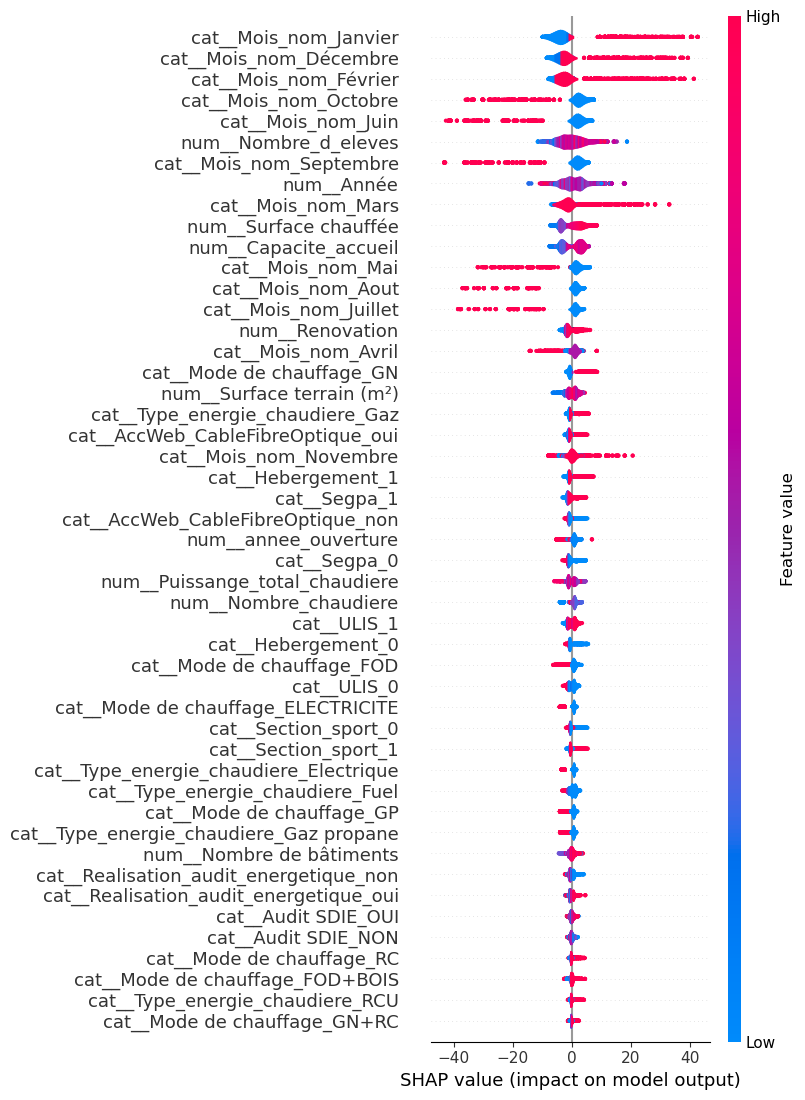

In [49]:
explainer = shap.Explainer(modele_rf['regressor'])
shap_values = explainer(modele_rf['preprocessor'].transform(X_test))

# Plot the summary plot
shap.summary_plot(shap_values, modele_rf['preprocessor'].transform(X_test),feature_names=modele_rf['preprocessor'].get_feature_names_out() ,plot_type="violin",max_display=len(modele_rf['preprocessor'].get_feature_names_out()),plot_size=0.2)

## XGBOOST

In [50]:
# def xgb_objective(trial):
#     n_estimators = trial.suggest_int('n_estimators', 10, 500)
#     max_depth = trial.suggest_int('max_depth', 1, 100)
#     learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1)
#     gamma = trial.suggest_float('gamma', 0, 1,step=0.01)
#     subsample = trial.suggest_float('subsample', 0.5, 1,step=0.01)
#     reg_alpha = trial.suggest_float('reg_alpha', 0, 1,step=0.01)
#     reg_lambda = trial.suggest_float('reg_lambda', 0, 1,step=0.01)
    
    
#     model = Pipeline(steps=[
#     ('preprocessor', preprocessor),
#     ('regressor', xgb.XGBRegressor(objective='reg:squarederror',n_estimators=n_estimators, max_depth=max_depth, learning_rate=learning_rate, random_state=42, verbosity=0,
#                              gamma=gamma, subsample=subsample,reg_alpha = reg_alpha, reg_lambda = reg_lambda))
# ])
    
#     model.fit(X_train, y_train)
#     y_pred = model.predict(X_test)
    
#     annual_data_pred = pd.concat([X_test.reset_index(drop=True), pd.Series(y_pred**2,name="Energie_totale")],axis=1)
#     annual_data_pred = annual_data_pred[["Année","Energie_totale"]].groupby(by="Année",as_index=False).sum()
    
#     return mean_squared_error(annual_data_test["Energie_totale"], annual_data_pred["Energie_totale"],squared=False)


# xgb_study = optuna.create_study(direction='minimize')
# xgb_study.optimize(xgb_objective, n_trials=100)

In [51]:
#best_xgb_params = xgb_study.best_params
#best_xgb_params = {'n_estimators': 186, 'max_depth': 92, 'learning_rate': 0.23848996985140367, 'gamma': 0.34, 'subsample': 0.56, 'reg_alpha': 0.68, 'reg_lambda': 0.67} # Avec surface chauffée, surface terrain, capacite_accueil, annee_ouverture Sans surface chauffée
#best_xgb_params = {'n_estimators': 412, 'max_depth': 55, 'learning_rate': 0.05288354927353133, 'gamma': 0.09, 'subsample': 0.58, 'reg_alpha': 0.6, 'reg_lambda': 0.68} # Sans surface chauffée, surface terrain, capacite_accueil, annee_ouverture Avec Surface plancher
#best_xgb_params = {'n_estimators': 223, 'max_depth': 3, 'learning_rate': 0.3726168417796798, 'gamma': 1.0, 'subsample': 0.69, 'reg_alpha': 0.03, 'reg_lambda': 0.5}  # Annual RMSE: Avec surface chauffée, surface terrain, capacite_accueil, annee_ouverture Sans surface plancher
best_xgb_params ={'n_estimators': 213, 'max_depth': 87, 'learning_rate': 0.9917619306645512, 'gamma': 0.74, 'subsample': 0.62, 'reg_alpha': 0.5, 'reg_lambda': 0.6}  # Annual RMSE sur données augmentées: Avec surface chauffée, surface terrain, capacite_accueil, annee_ouverture Sans surface plancher


modele_xgb = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', xgb.XGBRegressor(objective='reg:squarederror', n_estimators=best_xgb_params['n_estimators'], max_depth=best_xgb_params['max_depth'], 
                              learning_rate=best_xgb_params['learning_rate'], verbosity=0,
                              gamma=best_xgb_params['gamma'], subsample=best_xgb_params['subsample'],
                              reg_alpha=best_xgb_params['reg_alpha'], reg_lambda=best_xgb_params['reg_lambda'],
                              random_state=42))
])
modele_xgb.fit(X_train, y_train)
y_pred_xgb = modele_xgb.predict(X_test)
R_squared_xgb_train = modele_xgb.score(X_train,y_train)

annual_data_pred_xgb = pd.concat([X_test.reset_index(drop=True), pd.Series(y_pred_xgb**2,name="Energie_totale")],axis=1)
annual_data_pred_xgb = annual_data_pred_xgb[["Année","Energie_totale"]].groupby(by="Année",as_index=False).sum()

mse_xgb = mean_squared_error(annual_data_test["Energie_totale"], annual_data_pred_xgb["Energie_totale"])
mae_xgb = mean_absolute_error(annual_data_test["Energie_totale"], annual_data_pred_xgb["Energie_totale"])

In [52]:
np.sqrt(mse_xgb)

201511.7810774394

In [53]:
from sklearn.model_selection import cross_val_score, KFold
kf = KFold(n_splits=10, shuffle=True, random_state=42)
cv_scores = []
    
for train_index, test_index in kf.split(test_donnees_modele):
        X_train_cv, X_test_cv = test_donnees_modele.iloc[train_index], test_donnees_modele.iloc[test_index]
        y_train_cv, y_test_cv = test["Energie_totale"].iloc[train_index], test["Energie_totale"].iloc[test_index]
        
        #modele_xgb.fit(X_train, y_train)
        y_pred_cv = modele_xgb.predict(X_test_cv)
        
        # Agrégation annuelle des prédictions
        test_data_pred_cv = pd.concat([X_test_cv.reset_index(drop=True), pd.Series(y_pred_cv**2, name="Consommation_pred")], axis=1)
        annual_pred_cv = test_data_pred_cv.groupby(['Année'], as_index=False).agg({'Consommation_pred': 'sum'})
        annual_true = test.reset_index().loc[test_index].groupby(['Année'], as_index=False).agg({'Energie_totale': 'sum'})
        
        # Calcul de l'erreur quadratique moyenne annuelle
        mse = mean_squared_error(annual_true['Energie_totale'], annual_pred_cv['Consommation_pred'])
        cv_scores.append(np.sqrt(mse))

print("Moyenne de l'erreur quadratique moyenne sur la validation croisée : ", np.mean(cv_scores))

cv_scores=[]

annual_data_true = test[["Année","Energie_totale"]].groupby(by="Année",as_index=False).sum()
annual_data_true["Energie_totale"].describe()

Moyenne de l'erreur quadratique moyenne sur la validation croisée :  29118.327816660407


count    6.000000e+00
mean     8.393834e+06
std      8.145821e+05
min      7.104234e+06
25%      8.127317e+06
50%      8.419195e+06
75%      8.747087e+06
max      9.533969e+06
Name: Energie_totale, dtype: float64

In [54]:
# modele_xgb = Pipeline(steps=[
#     ('preprocessor', preprocessor),
#     ('regressor', xgb.XGBRegressor(objective='reg:squarederror',n_estimators= 313, max_depth= 23, 
#                               learning_rate= 0.028574004928199736, gamma= 0.18, subsample= 0.54, 
#                               reg_alpha= 0.98, reg_lambda= 0.8,
#                               random_state=42, verbosity=0))
# ])

# modele_xgb.fit(X_train, y_train)
# y_pred_xgb = modele_xgb.predict(X_test)
# R_squared_xgb_train = modele_xgb.score(X_train,y_train)
# mse_xgb = mean_squared_error(y_test**2, y_pred_xgb**2)
# mae_xgb = mean_absolute_error(y_test**2, y_pred_xgb**2)

In [55]:
#fig = plt.figure(figsize=(12, 8))
#ax = fig.add_subplot(111, ylabel="Observed Values", xlabel="Fitted Values")
#ax.scatter(y_pred, y_test)
#y_vs_yhat = sm.OLS(y_test, sm.add_constant(y_pred, prepend=True)).fit()
#fig = abline_plot(model_results=y_vs_yhat, ax=ax, color="red")

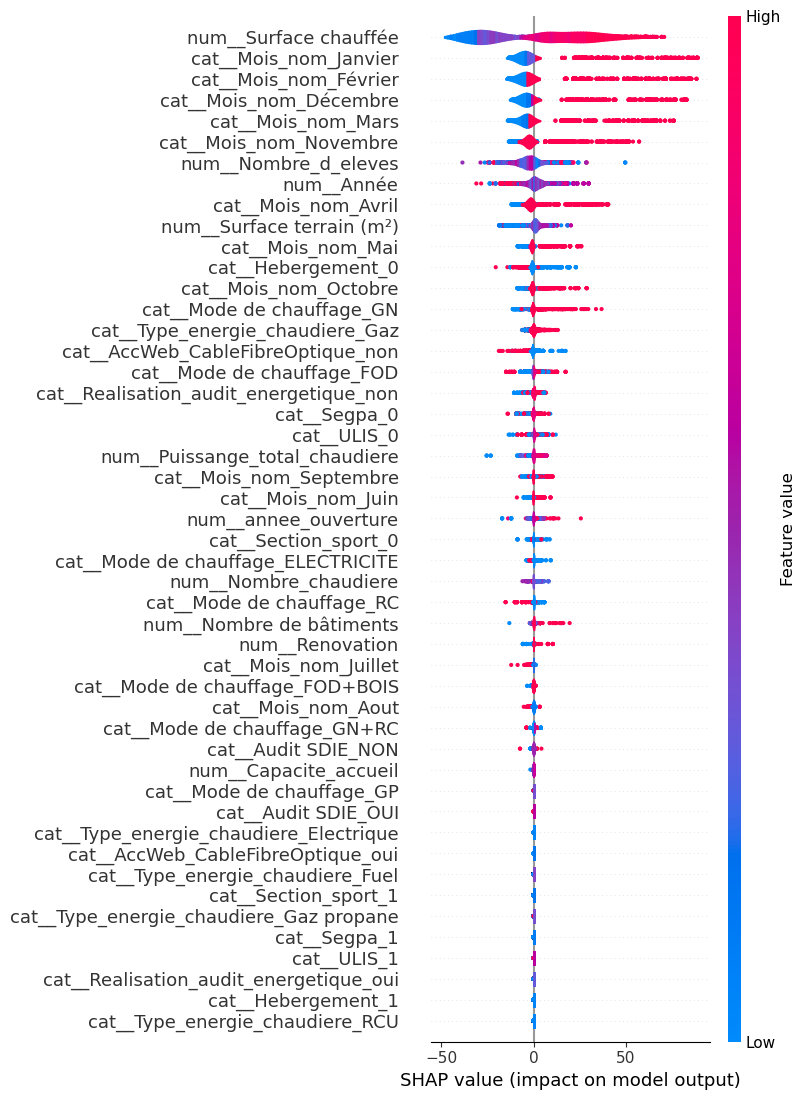

In [56]:
explainer = shap.Explainer(modele_xgb['regressor'])
shap_values = explainer(modele_xgb['preprocessor'].transform(X_test))

# Plot the summary plot
shap.summary_plot(shap_values, modele_xgb['preprocessor'].transform(X_test),feature_names=modele_xgb['preprocessor'].get_feature_names_out() ,plot_type="violin",max_display=len(modele_xgb['preprocessor'].get_feature_names_out()),plot_size=0.2)

In [57]:
#xgb.plot_importance(modele_xgb)

## Light GBM

In [58]:
# def lgb_objective(trial):
#     boosting_type = trial.suggest_categorical('boosting_type',['gbdt','rf','dart'])
#     n_estimators = trial.suggest_int('n_estimators', 10, 500)
#     max_depth = trial.suggest_int('max_depth', 2, 500)
#     num_leaves = trial.suggest_int('num_leaves', 3, 200) 
#     learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1)
#     subsample = trial.suggest_float('subsample', 0.5, 1,step=0.01)
#     n_jobs = trial.suggest_int('n_jobs', 1, 4)
#     importance_type = trial.suggest_categorical('importance_type',['split','gain'])
#     bagging_freq = trial.suggest_int('bagging_freq', 1, 10)
#     bagging_fraction = trial.suggest_float('bagging_fraction', 0, 1)
#     feature_fraction = trial.suggest_float('feature_fraction', 0, 1)
#     reg_alpha = trial.suggest_float('reg_alpha', 0, 1)
#     reg_lambda = trial.suggest_float('reg_lambda', 0, 1)
    
#     model = Pipeline(steps=[
#     ('preprocessor', preprocessor),
#     ('regressor', lgb.LGBMRegressor(objective='regression',boosting_type=boosting_type,n_estimators=n_estimators, max_depth=max_depth, learning_rate=learning_rate, random_state=42, verbose=-1,
#                               subsample=subsample, n_jobs=n_jobs, importance_type=importance_type, num_leaves=num_leaves,
#                               bagging_freq=bagging_freq, bagging_fraction=bagging_fraction, feature_fraction=feature_fraction,
#                               reg_alpha=reg_alpha, reg_lambda=reg_lambda))
# ])
    
#     model.fit(X_train, y_train)
#     y_pred = model.predict(X_test)
    
#     annual_data_pred = pd.concat([X_test.reset_index(drop=True), pd.Series(y_pred**2,name="Energie_totale")],axis=1)
#     annual_data_pred = annual_data_pred[["Année","Energie_totale"]].groupby(by="Année",as_index=False).sum()
    
#     return mean_squared_error(annual_data_test["Energie_totale"], annual_data_pred["Energie_totale"])


# lgb_study = optuna.create_study(direction='minimize')
# lgb_study.optimize(lgb_objective, n_trials=100)

In [59]:
#best_lgb_params = lgb_study.best_params
# best_lgb_params = {'boosting_type': 'dart', 'n_estimators': 485, 'max_depth': 162, 'num_leaves': 61, 
#                    'learning_rate': 0.44086699704683135, 'subsample': 0.51, 'n_jobs': 4, 'importance_type': 'split', 
#                    'bagging_freq': 2, 'bagging_fraction': 0.9137886813318662, 'feature_fraction': 0.9996779140673215, 'reg_alpha': 0.060380412241567774, 'reg_lambda': 0.020964277826202735} # Avec surface chauffée, surface terrain, capacite_accueil, annee_ouverture Sans surface chauffée

# best_lgb_params = {'boosting_type': 'gbdt', 'n_estimators': 488, 'max_depth': 454, 'num_leaves': 71, 
#                   'learning_rate': 0.05774731285017231, 'subsample': 0.9, 'n_jobs': 1, 'importance_type': 'split', 
#                   'bagging_freq': 3, 'bagging_fraction': 0.9982416981115241, 'feature_fraction': 0.8850223529307928, 'reg_alpha': 0.37245435342310484, 'reg_lambda': 0.9213240443493709} # Sans surface chauffée, surface terrain, capacite_accueil, annee_ouverture Avec Surface plancher

# best_lgb_params = {'boosting_type': 'gbdt', 'n_estimators': 200, 'max_depth': 83, 'num_leaves': 158, 
#                    'learning_rate': 0.8456220305448303, 'subsample': 0.94, 'n_jobs': 2, 'importance_type': 'gain', 
#                    'bagging_freq': 5, 'bagging_fraction': 0.8321631228261512, 'feature_fraction': 0.5622161358252253, 'reg_alpha': 0.7803320243590194, 'reg_lambda': 0.8829793515223412}  # Annual RMSE: Avec surface chauffée, surface terrain, capacite_accueil, annee_ouverture Sans surface plancher

best_lgb_params = {'boosting_type': 'gbdt', 'n_estimators': 262, 'max_depth': 465, 'num_leaves': 180, 
                   'learning_rate': 0.6949203745176613, 'subsample': 0.8, 'n_jobs': 2, 'importance_type': 'split', 
                   'bagging_freq': 1, 'bagging_fraction': 0.8585314703347148, 'feature_fraction': 0.3348002182298498, 'reg_alpha': 0.6658147838927967, 'reg_lambda': 0.7969465359807189}  # Annual RMSE sur données augmentées: Avec surface chauffée, surface terrain, capacite_accueil, annee_ouverture Sans surface plancher


modele_lgb = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', lgb.LGBMRegressor(objective='regression', boosting_type=best_lgb_params['boosting_type'], num_leaves=best_lgb_params['num_leaves'], 
                               learning_rate=best_lgb_params['learning_rate'], n_estimators=best_lgb_params['n_estimators'],verbose=-1,
                               max_depth=best_lgb_params['max_depth'],
                               n_jobs=best_lgb_params['n_jobs'], importance_type=best_lgb_params['importance_type'],
                               subsample=best_lgb_params['subsample'], bagging_freq=best_lgb_params['bagging_freq'],
                               bagging_fraction=best_lgb_params['bagging_fraction'],feature_fraction=best_lgb_params['feature_fraction'],
                               reg_alpha=best_lgb_params['reg_alpha'],reg_lambda=best_lgb_params['reg_lambda']))
])

# Train the model
modele_lgb.fit(X_train, y_train)
y_pred_lgb = modele_lgb.predict(X_test)
R_squared_lgb_train = modele_lgb.score(X_train,y_train)

annual_data_pred_lgb = pd.concat([X_test.reset_index(drop=True), pd.Series(y_pred_lgb**2,name="Energie_totale")],axis=1)
annual_data_pred_lgb = annual_data_pred_lgb[["Année","Energie_totale"]].groupby(by="Année",as_index=False).sum()

mse_lgb = mean_squared_error(annual_data_test["Energie_totale"], annual_data_pred_lgb["Energie_totale"])
mae_lgb = mean_absolute_error(annual_data_test["Energie_totale"], annual_data_pred_lgb["Energie_totale"])

In [60]:
# modele_lgb = Pipeline(steps=[
#     ('preprocessor', preprocessor),
#     ('regressor', lgb.LGBMRegressor(objective='regression',boosting_type = 'dart', n_estimators = 482, max_depth = 302,
#                                 num_leaves = 169, learning_rate = 0.16583585841091095, subsample = 0.88, 
#                                 n_jobs = 3, importance_type = 'gain', bagging_freq = 7, bagging_fraction = 0.8265290019353083, 
#                                 feature_fraction = 0.8779672886111856, reg_alpha = 0.6493280874417041, reg_lambda = 0.8797489587894971,
#                                verbose=0))
# ])

# # Train the model
# modele_lgb.fit(X_train, y_train)
# y_pred_lgb = modele_lgb.predict(X_test)
# R_squared_lgb_train = modele_lgb.score(X_train,y_train)
# mse_lgb = mean_squared_error(y_test**2, y_pred_lgb**2)
# mae_lgb = mean_absolute_error(y_test**2, y_pred_lgb**2)


In [61]:
#fig = plt.figure(figsize=(12, 8))
#ax = fig.add_subplot(111, ylabel="Observed Values", xlabel="Fitted Values")
#ax.scatter(y_pred, y_test)
#y_vs_yhat = sm.OLS(y_test, sm.add_constant(y_pred, prepend=True)).fit()
#fig = abline_plot(model_results=y_vs_yhat, ax=ax, color="red")

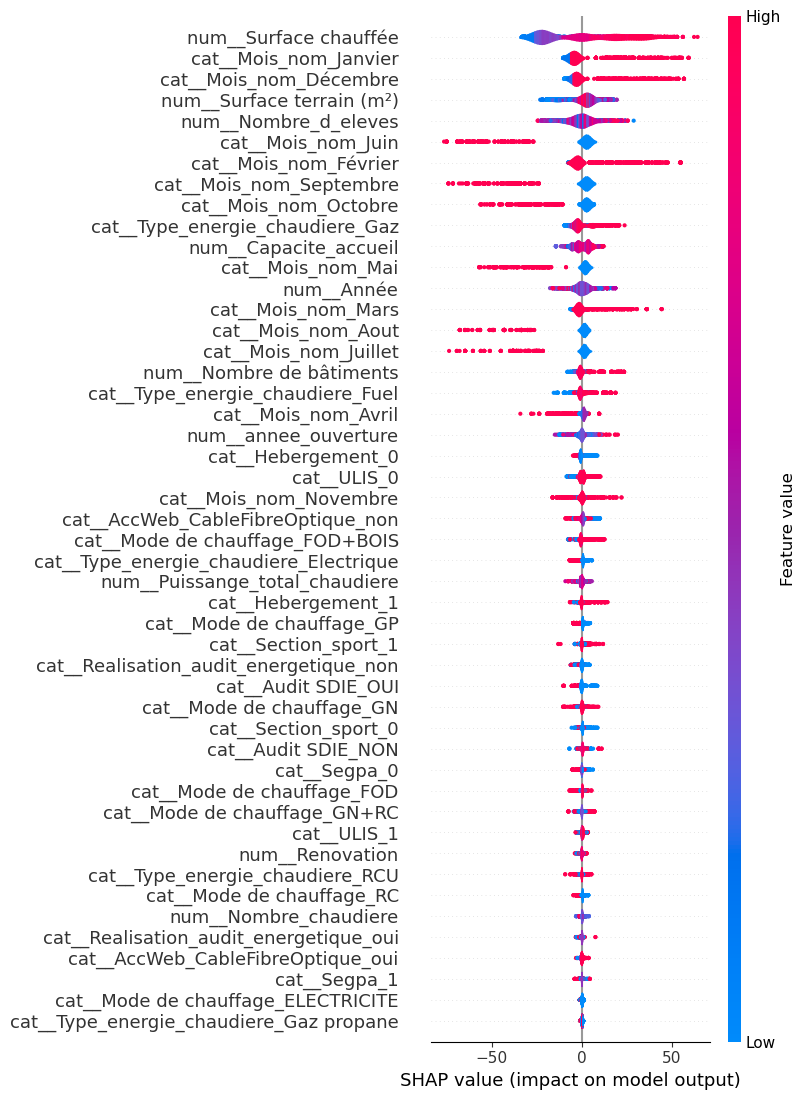

In [62]:
explainer = shap.Explainer(modele_lgb['regressor'])
shap_values = explainer(modele_lgb['preprocessor'].transform(X_test))

# Plot the summary plot
shap.summary_plot(shap_values, modele_lgb['preprocessor'].transform(X_test),feature_names=modele_lgb['preprocessor'].get_feature_names_out() ,plot_type="violin",max_display=len(modele_lgb['preprocessor'].get_feature_names_out()),plot_size=0.2)

## HistGradientBoosting

In [63]:
# def hgb_objective(trial):
#     max_depth = trial.suggest_int('max_depth', 1, 100)
#     max_iter = trial.suggest_int('max_iter', 1, 500)
#     interaction_cst = trial.suggest_categorical('interaction_cst',['pairwise','no_interactions',None])
#     learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1)
#     warm_start = trial.suggest_categorical('warm_start',[False,True])
    
    
#     model = Pipeline(steps=[
#     ('preprocessor', preprocessor),
#     ('regressor', HistGradientBoostingRegressor( max_depth=max_depth, learning_rate=learning_rate, random_state=42, verbose=0,
#                               max_iter=max_iter,warm_start=warm_start,validation_fraction=0.2, interaction_cst=interaction_cst))
# ])
    
#     model.fit(X_train, y_train)
#     y_pred = model.predict(X_test)
    
#     annual_data_pred = pd.concat([X_test.reset_index(drop=True), pd.Series(y_pred**2,name="Energie_totale")],axis=1)
#     annual_data_pred = annual_data_pred[["Année","Energie_totale"]].groupby(by="Année",as_index=False).sum()
    
#     return mean_squared_error(annual_data_test["Energie_totale"], annual_data_pred["Energie_totale"])


# hgb_study = optuna.create_study(direction='minimize')
# hgb_study.optimize(hgb_objective, n_trials=100)

In [64]:
#best_hgb_params = hgb_study.best_params
# best_hgb_params = {'max_depth': 93, 'max_iter': 332, 'interaction_cst': None, 'learning_rate': 0.03518602985202431, 'warm_start': False} # Avec surface chauffée, surface terrain, capacite_accueil, annee_ouverture Sans surface chauffée
#best_hgb_params = {'max_depth': 30, 'max_iter': 198, 'interaction_cst': None, 'learning_rate': 0.12103094486982814, 'warm_start': True} # Sans surface chauffée, surface terrain, capacite_accueil, annee_ouverture Avec Surface plancher
#best_hgb_params = {'max_depth': 83, 'max_iter': 227, 'interaction_cst': None, 'learning_rate': 0.23254152645016057, 'warm_start': True}  # Annual RMSE: Avec surface chauffée, surface terrain, capacite_accueil, annee_ouverture Sans surface plancher
best_hgb_params = {'max_depth': 49, 'max_iter': 310, 'interaction_cst': None, 'learning_rate': 0.9654654409746862, 'warm_start': True} # Annual RMSE sur données augmentées: Avec surface chauffée, surface terrain, capacite_accueil, annee_ouverture Sans surface plancher


modele_hgb = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', HistGradientBoostingRegressor(max_iter=best_hgb_params['max_iter'], max_depth=best_hgb_params['max_depth'], learning_rate=best_hgb_params['learning_rate'],
                                           warm_start=best_hgb_params['warm_start'],interaction_cst=best_hgb_params['interaction_cst'],
                                           verbose=0, random_state=42, validation_fraction=0.2))
])

# Train the model
modele_hgb.fit(X_train, y_train)
y_pred_hgb = modele_hgb.predict(X_test)
R_squared_hgb_train = modele_hgb.score(X_train,y_train)

annual_data_pred_hgb = pd.concat([X_test.reset_index(drop=True), pd.Series(y_pred_hgb**2,name="Energie_totale")],axis=1)
annual_data_pred_hgb = annual_data_pred_hgb[["Année","Energie_totale"]].groupby(by="Année",as_index=False).sum()

mse_hgb = mean_squared_error(annual_data_test["Energie_totale"], annual_data_pred_hgb["Energie_totale"])
mae_hgb = mean_absolute_error(annual_data_test["Energie_totale"], annual_data_pred_hgb["Energie_totale"])


In [65]:
# modele_hgb = Pipeline(steps=[
#     ('preprocessor', preprocessor),
#     ('regressor', HistGradientBoostingRegressor(max_iter=262, max_depth=49, learning_rate=0.062121945018331494,
#                                            warm_start=True,interaction_cst=None,
#                                            verbose=0, random_state=42, validation_fraction=0.2))
# ])


# # Train the model
# modele_hgb.fit(X_train, y_train)
# y_pred_hgb = modele_hgb.predict(X_test)
# R_squared_hgb_train = modele_hgb.score(X_train,y_train)
# mse_hgb = mean_squared_error(y_test**2, y_pred_hgb**2)
# mae_hgb = mean_absolute_error(y_test**2, y_pred_hgb**2)


In [66]:
#fig = plt.figure(figsize=(12, 8))
#ax = fig.add_subplot(111, ylabel="Observed Values", xlabel="Fitted Values")
#ax.scatter(y_pred, y_test)
#y_vs_yhat = sm.OLS(y_test, sm.add_constant(y_pred, prepend=True)).fit()
#fig = abline_plot(model_results=y_vs_yhat, ax=ax, color="red")

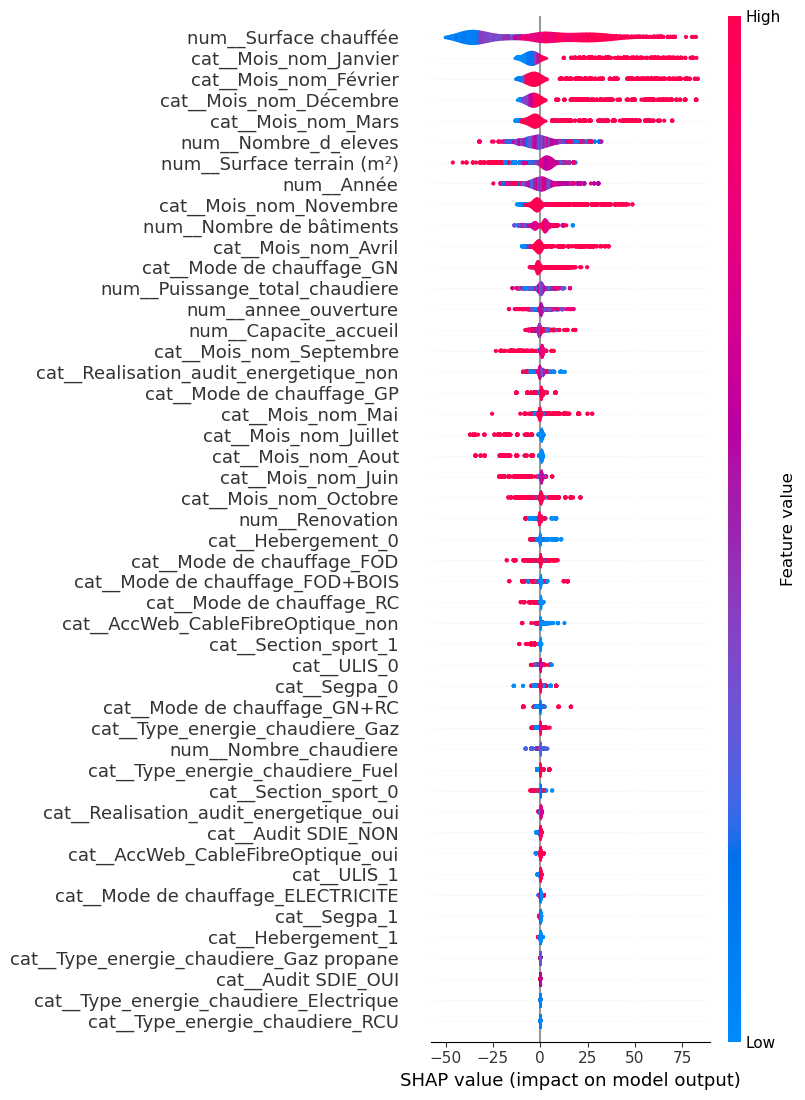

In [67]:
explainer = shap.Explainer(modele_hgb['regressor'])
shap_values = explainer(modele_hgb['preprocessor'].transform(X_test))

# Plot the summary plot
shap.summary_plot(shap_values, modele_hgb['preprocessor'].transform(X_test),feature_names=modele_hgb['preprocessor'].get_feature_names_out() ,plot_type="violin",max_display=len(modele_hgb['preprocessor'].get_feature_names_out()),plot_size=0.2)

### Neural network

In [68]:
# preprocessor_cnn = ColumnTransformer(
#     transformers=[
#         ('cat', OneHotEncoder(handle_unknown='ignore'), variables_cat),
#         ('num', StandardScaler(), [item for item in variables_a_garder if item not in var_a_supp])
#     ])

# def reshape_for_cnn(X):
#     return np.expand_dims(X, axis=-1)

In [69]:
# X_train_transformed = reshape_for_cnn(preprocessor_cnn.fit_transform(X_train))
# X_test_transformed = reshape_for_cnn(preprocessor_cnn.transform(X_test))

In [70]:
# def create_cnn_model(input_shape,optimizer,filters,kernel_size,pool_size,
#                      activation1,activation2,activation3,activation4,activation5,activation6,
#                      units1,units2,units3,units4,units5):
#     model = keras.Sequential([
#     keras.layers.Conv1D(filters=filters, kernel_size=kernel_size, activation=activation1, input_shape=input_shape), 
#     keras.layers.MaxPooling1D(pool_size=pool_size),
#     keras.layers.Flatten(),
#     keras.layers.Dense(units1, activation=activation2),
#     keras.layers.Dense(units2, activation=activation3),
#     keras.layers.Dense(units3, activation=activation4),
#     keras.layers.Dense(units4, activation= activation5),
#     keras.layers.Dense(units5, activation=activation6),
#     keras.layers.Dense(1)  # Output layer with 1 neuron for regression
# ])
#     model.compile(optimizer=optimizer, loss='mean_squared_error')
#     return model

In [71]:
# def cnn_objective(trial):
#     optimizer = trial.suggest_categorical('optimizer',['adam','rmsprop','adadelta','adagrad','adamax','nadam'])
#     filters = trial.suggest_int('filters', 32, 1024)
#     kernel_size = trial.suggest_int('kernel_size', 2, 10)
#     pool_size = trial.suggest_int('pool_size', 1, 10)
#     activation1 = trial.suggest_categorical('activation1',['relu','softplus','linear','tanh'])
#     activation2 = trial.suggest_categorical('activation2',['relu','softplus','linear','tanh'])
#     activation3 = trial.suggest_categorical('activation3',['relu','softplus','linear','tanh'])
#     activation4 = trial.suggest_categorical('activation4',['relu','softplus','linear','tanh'])
#     activation5 = trial.suggest_categorical('activation5',['relu','softplus','linear','tanh'])
#     activation6 = trial.suggest_categorical('activation6',['relu','softplus','linear','tanh'])
#     units1 = trial.suggest_int('units1',32,512)
#     units2 = trial.suggest_int('units2',32,512)
#     units3 = trial.suggest_int('units3',32,512)
#     units4 = trial.suggest_int('units4',32,512)
#     units5 = trial.suggest_int('units5',32,512)
#     epochs = trial.suggest_int('epochs', 10, 100)
#     batch_size = trial.suggest_int('batch_size', 32, 256)
    
    
#     modele_cnn = create_cnn_model((X_train_transformed.shape[1],1),optimizer,filters,kernel_size,pool_size,
#                      activation1,activation2,activation3,activation4,activation5,activation6,
#                      units1,units2,units3,units4,units5)

#     modele_cnn.fit(X_train_transformed, y_train, epochs=epochs, batch_size=batch_size, verbose=0)
#     y_pred = modele_cnn.predict(X_test_transformed)
#     y_pred_reshape = np.reshape(y_pred,np.shape(y_pred)[0])
    
#     annual_data_pred = pd.concat([X_test.reset_index(drop=True), pd.Series(y_pred_reshape**2,name="Energie_totale")],axis=1)
#     annual_data_pred = annual_data_pred[["Année","Energie_totale"]].groupby(by="Année",as_index=False).sum()
    
#     return mean_squared_error(annual_data_test["Energie_totale"], annual_data_pred["Energie_totale"])


# cnn_study = optuna.create_study(direction='minimize')
# cnn_study.optimize(cnn_objective, n_trials=100)

In [72]:
# #best_cnn_params = cnn_study.best_params 
# # best_cnn_params = {'optimizer': 'adamax', 'filters': 159, 'kernel_size': 2, 'pool_size': 2, 'activation1': 'tanh', 
# #                    'activation2': 'tanh', 'activation3': 'relu', 'activation4': 'softplus', 'activation5': 'tanh', 
# #                    'activation6': 'linear', 'units1': 320, 'units2': 99, 'units3': 48, 'units4': 281, 'units5': 434, 'epochs': 88, 'batch_size': 48} # Avec surface chauffée, surface terrain, capacite_accueil, annee_ouverture Sans surface chauffée

# best_cnn_params = {'optimizer': 'adamax', 'filters': 188, 'kernel_size': 2, 'pool_size': 2, 'activation1': 'linear', 
#                   'activation2': 'linear', 'activation3': 'tanh', 'activation4': 'tanh', 'activation5': 'linear', 'activation6': 'softplus', 
#                   'units1': 360, 'units2': 273, 'units3': 47, 'units4': 119, 'units5': 172, 'epochs': 51, 'batch_size': 51} # Sans surface chauffée, surface terrain, capacite_accueil, annee_ouverture Avec Surface plancher

# # best_rnn_params = {'optimizer': 'adamax', 'filters': 616, 'kernel_size': 7, 'pool_size': 9, 
# #                    'activation1': 'tanh', 'activation2': 'relu', 'activation3': 'linear', 'activation4': 'softplus', 'activation5': 'softplus', 'activation6': 'softplus', 
# #                    'units1': 98, 'units2': 214, 'units3': 244, 'units4': 448, 'units5': 152, 'epochs': 78, 'batch_size': 161} # Annual RMSE: Avec surface chauffée, surface terrain, capacite_accueil, annee_ouverture Sans surface plancher


# modele_cnn = create_cnn_model((X_train_transformed.shape[1],1),best_cnn_params['optimizer'],best_cnn_params['filters'],best_cnn_params['kernel_size'],best_cnn_params['pool_size'],
#                     best_cnn_params['activation1'],best_cnn_params['activation2'],best_cnn_params['activation3'],best_cnn_params['activation4'],best_cnn_params['activation5'],best_cnn_params['activation6'],
#                     best_cnn_params['units1'],best_cnn_params['units2'],best_cnn_params['units3'],best_cnn_params['units4'],best_cnn_params['units5'])


# modele_cnn.compile(optimizer=best_cnn_params['optimizer'], loss='mean_squared_error')
# modele_cnn.fit(X_train_transformed, y_train, epochs=best_cnn_params['epochs'], batch_size=best_cnn_params['batch_size'], verbose=0)

# y_pred_cnn = modele_cnn.predict(X_test_transformed)
# R_squared_cnn_train = r2_score(y_train,modele_cnn.predict(X_train_transformed))

# y_pred_cnn_reshaped = np.reshape(y_pred_cnn,np.shape(y_pred_cnn)[0])
# annual_data_pred_cnn = pd.concat([X_test.reset_index(drop=True), pd.Series(y_pred_cnn_reshaped**2,name="Energie_totale")],axis=1)
# annual_data_pred_cnn = annual_data_pred_cnn[["Année","Energie_totale"]].groupby(by="Année",as_index=False).sum()

# mse_cnn = mean_squared_error(annual_data_test["Energie_totale"], annual_data_pred_cnn["Energie_totale"])
# mae_cnn = mean_absolute_error(annual_data_test["Energie_totale"], annual_data_pred_cnn["Energie_totale"])


In [73]:
# modele_cnn = keras.Sequential([
#     keras.layers.Conv1D(filters=1002, kernel_size=6, activation='tanh', input_shape=(X_train.shape[1], 1)), 
#     keras.layers.MaxPooling1D(pool_size=1),
#     keras.layers.Flatten(),
#     keras.layers.Dense(410, activation='linear'),
#     keras.layers.Dense(355, activation='softplus'),
#     keras.layers.Dense(163, activation='tanh'),
#     keras.layers.Dense(179, activation= 'softplus'),
#     keras.layers.Dense(483, activation='linear'),
#     keras.layers.Dense(1)  # Output layer with 1 neuron for regression
# ])


# modele_cnn.compile(optimizer='adagrad', loss='mean_squared_error')
# modele_cnn.fit(X_train_scaled, y_train, epochs=82, batch_size=125, validation_data=(X_test_scaled, y_test),verbose=0)

# y_pred_cnn = modele_cnn.predict(X_test_scaled)
# R_squared_cnn_train = r2_score(y_train,modele_cnn.predict(X_train_scaled))
# mse_cnn = mean_squared_error(y_test**2, y_pred_cnn**2)
# mae_cnn = mean_absolute_error(y_test**2, y_pred_cnn**2)

In [74]:
# preprocessor_cnn = ColumnTransformer(
#     transformers=[
#         ('cat', OneHotEncoder(handle_unknown='ignore'), variables_cat),
#         ('num', StandardScaler(), [item for item in variables_a_garder if item not in var_a_supp])
#     ])

In [75]:
# def create_cnn_model(input_shape):
#     model = keras.Sequential([
#     keras.layers.Conv1D(filters=1002, kernel_size=6, activation='tanh', input_shape=input_shape), 
#     keras.layers.MaxPooling1D(pool_size=1),
#     keras.layers.Flatten(),
#     keras.layers.Dense(410, activation='linear'),
#     keras.layers.Dense(355, activation='softplus'),
#     keras.layers.Dense(163, activation='tanh'),
#     keras.layers.Dense(179, activation= 'softplus'),
#     keras.layers.Dense(483, activation='linear'),
#     keras.layers.Dense(1)  # Output layer with 1 neuron for regression
# ])
#     model.compile(optimizer='adagrad', loss='mean_squared_error')
#     return model

In [76]:
# def reshape_for_cnn(X):
#     return np.expand_dims(X, axis=-1)

#reshape_transformer = FunctionTransformer(reshape_for_cnn, validate=False)

In [77]:
# X_train_transformed = reshape_for_cnn(preprocessor_cnn.fit_transform(X_train))
# X_test_transformed = reshape_for_cnn(preprocessor_cnn.transform(X_test))

In [78]:
# modele_cnn = create_cnn_model((X_train_transformed.shape[1],1))

# modele_cnn.fit(X_train_transformed, y_train, epochs=82, batch_size=125, verbose=0)

# y_pred_cnn = modele_cnn.predict(X_test_transformed)
# R_squared_cnn_train = r2_score(y_train,modele_cnn.predict(X_train_transformed))
# mse_cnn = mean_squared_error(y_test**2, y_pred_cnn**2)
# mae_cnn = mean_absolute_error(y_test**2, y_pred_cnn**2)

In [79]:
#fig = plt.figure(figsize=(12, 8))
#ax = fig.add_subplot(111, ylabel="Observed Values", xlabel="Fitted Values")
#ax.scatter(y_pred, y_test)
#y_vs_yhat = sm.OLS(y_test, sm.add_constant(y_pred, prepend=True)).fit()
#fig = abline_plot(model_results=y_vs_yhat, ax=ax, color="red")

In [80]:
# X_train_preprocessed = preprocessor_cnn.transform(X_train)
# X_test_preprocessed = preprocessor_cnn.transform(X_test)

# explainer = shap.Explainer(modele_cnn, X_train_preprocessed)
# shap_values = explainer.shap_values(X_test_preprocessed)

# # Plot the summary plot
# shap.summary_plot(shap_values, X_test_preprocessed,feature_names=X_test_preprocessed.columns,
#                   plot_type="violin",max_display=len(X_test_preprocessed.columns),plot_size=0.2)

# Stacking

In [81]:
regres = [('LGBM',modele_lgb),('RF',modele_rf),('XGB',modele_xgb),('HGB',modele_hgb)]
stack_model = StackingRegressor( estimators = regres,final_estimator=HistGradientBoostingRegressor(),cv=7,n_jobs=-1,verbose=0)
# Pipeline(steps=[
#     ('preprocessor', preprocessor),
#     ('regressor', StackingRegressor( estimators = regres,final_estimator=RandomForestRegressor(),cv=50,n_jobs=7,verbose=0))
# ])

modele_stack = stack_model.fit(X_train,y_train)
y_pred_stack = modele_stack.predict(X_test)

R_squared_stack_train = r2_score(y_train,modele_stack.predict(X_train))

annual_data_pred_stack = pd.concat([X_test.reset_index(drop=True), pd.Series(y_pred_stack**2,name="Energie_totale")],axis=1)
annual_data_pred_stack = annual_data_pred_stack[["Année","Energie_totale"]].groupby(by="Année",as_index=False).sum()

mse_stack = mean_squared_error(annual_data_test["Energie_totale"], annual_data_pred_stack["Energie_totale"])
mae_stack = mean_absolute_error(annual_data_test["Energie_totale"], annual_data_pred_stack["Energie_totale"])


## Evaluer la MSE sur le jeu de données final (sans augmentation)

## Résumé

In [82]:
liste_modeles = ["GLM","RF","XGboost","Light GBM","HistGradientBoosting","Stacking"]
liste_R_squared = [f"{np.round(R_squared_glm_train*100,2)} %",f"{np.round(R_squared_rf_train*100,2)} %",
                   f"{np.round(R_squared_xgb_train*100,2)} %",f"{np.round(R_squared_lgb_train*100,2)} %",
                   f"{np.round(R_squared_hgb_train*100,2)} %",f"{np.round(R_squared_stack_train*100,2)} %"]
liste_mae = [np.round(mae_glm,2),np.round(mae_rf,2),np.round(mae_xgb,2),np.round(mae_lgb,2),np.round(mae_hgb,2),np.round(mae_stack,2)]
liste_rmse = [np.round(np.sqrt(mse_glm),2),np.round(np.sqrt(mse_rf),2),np.round(np.sqrt(mse_xgb),2),np.round(np.sqrt(mse_lgb),2),
              np.round(np.sqrt(mse_hgb),2),np.round(np.sqrt(mse_stack),2)]

resume = pd.DataFrame({
    "Modèle": liste_modeles,
    "R_carré": liste_R_squared,
    "Annual MAE": liste_mae,
    "Annual RMSE": liste_rmse
})

resume

,Modèle,R_carré,Annual MAE,Annual RMSE
0,GLM,72.7 %,983605.08,1482334.81
1,RF,99.9 %,164106.03,218918.79
2,XGboost,100.0 %,149553.97,201511.78
3,Light GBM,99.9 %,171951.93,246437.37
4,HistGradientBoosting,99.76 %,126085.17,194529.62
5,Stacking,99.92 %,160362.68,236553.99


In [83]:
annual_data_test["Energie_totale"].describe()

count    6.000000e+00
mean     2.383238e+07
std      2.534647e+06
min      2.023878e+07
25%      2.338194e+07
50%      2.359871e+07
75%      2.396117e+07
max      2.816640e+07
Name: Energie_totale, dtype: float64

Le modèle prédit avec une erreur moyenne de "RMSE" kWh/m2. <br>
Sachant que l'énergie totale varie de 5.38 kWh/m2 à 56.77 kWh/m2; avec un écart-type de 4.2 kWh/m2; <br>
 

In [84]:
print(f"Rf: {best_rf_params} \n")
print(f"XGB: {best_xgb_params} \n")
print(f"LGB: {best_lgb_params} \n")
print(f"HGB: {best_hgb_params} \n")
#print(f"CNN: {best_cnn_params is None} \n")

Rf: {'n_estimators': 454, 'max_depth': 304, 'max_features': 1, 'n_jobs': 2} 

XGB: {'n_estimators': 213, 'max_depth': 87, 'learning_rate': 0.9917619306645512, 'gamma': 0.74, 'subsample': 0.62, 'reg_alpha': 0.5, 'reg_lambda': 0.6} 

LGB: {'boosting_type': 'gbdt', 'n_estimators': 262, 'max_depth': 465, 'num_leaves': 180, 'learning_rate': 0.6949203745176613, 'subsample': 0.8, 'n_jobs': 2, 'importance_type': 'split', 'bagging_freq': 1, 'bagging_fraction': 0.8585314703347148, 'feature_fraction': 0.3348002182298498, 'reg_alpha': 0.6658147838927967, 'reg_lambda': 0.7969465359807189} 

HGB: {'max_depth': 49, 'max_iter': 310, 'interaction_cst': None, 'learning_rate': 0.9654654409746862, 'warm_start': True} 



# Test

In [85]:
#pb = X_test.iloc[np.where(y_test>6)] ## Outliers sur graphe observed values by fitted values
#pb

In [86]:
### Graphe interactions entre vars

#num_vars = len(test_donnees_modele.columns)
#num_cols = 2
#num_rows = math.ceil(len(test_donnees_modele.columns)//2)

#fig,axes = plt.subplots(nrows = num_rows ,ncols=num_cols, figsize=(16, 3 * num_rows))
#axes = axes.flatten()

# Iterate over each independent variable and create a scatterplot
#for i, col in enumerate(test_donnees_modele.columns):
#    ax = axes[i-1]
#    ax.scatter(test_donnees_modele[col], test["Energie_totale"], alpha=0.5)
#    ax.set_xlabel(col)
#    ax.set_ylabel('Energie_totale(en kWh/m2)')

# Remove empty subplots if needed
#for j in range(num_vars, num_cols * num_rows):
#    fig.delaxes(axes[j])
    
#plt.tight_layout()
#plt.show()

In [87]:
reel_et_pred = pd.DataFrame({
    "Année": test_donnees_modele["Année"], "Reel": test["Energie_totale"], "Pred":modele_xgb.predict(test_donnees_modele)**2
})
reel_et_pred_group = reel_et_pred.groupby(by="Année",as_index=False).sum()


In [88]:
def millions(x, pos):
    return f'{int(x):,}'.replace(',', ' ')

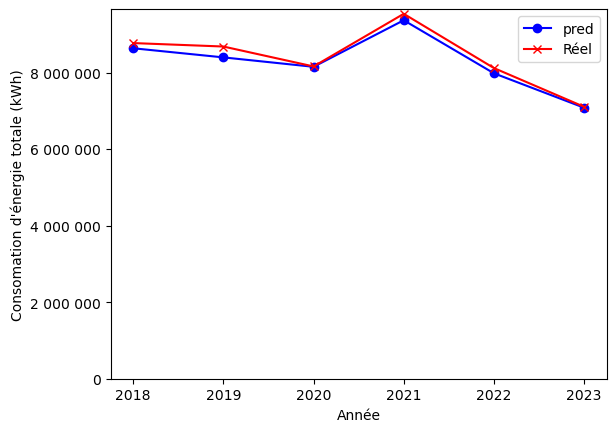

In [89]:
plt.figure()

plt.plot(reel_et_pred_group["Année"], reel_et_pred_group["Pred"], label='pred', color='blue', marker='o')
plt.plot(reel_et_pred_group["Année"], reel_et_pred_group["Reel"], label='Réel', color='red', marker='x')

plt.ylim(0,)
plt.gca().get_yaxis().set_major_formatter(FuncFormatter(millions))

plt.xlabel("Année")
plt.ylabel("Consomation d'énergie totale (kWh)")
plt.legend()
plt.show()

# Test normalité et test d'hétéroscedasticité pas obligatoire en Machine Learning (pour les modèles d'apprentissage, tq RF, XGBoost, etc.)

Mais faudrait le faire quand meme pour connaitre les limites du modele

Si la variable dépendante ne suit pas une distribution normale, alors ces tests ne reflètent pas les vrais performances du modèle, car ils partent de l'hypothèse que la var dépendante suit une distribution normale

In [90]:
from scipy.stats import shapiro
from statsmodels.stats.diagnostic import het_breuschpagan
#y_pred = modele_xgb.predict(X_test)
test_residus = reel_et_pred["Reel"] - reel_et_pred["Pred"] 
train_residus = y_train - modele_xgb.predict(X_train)
#residus = residus[:1000]
shapiro_test_statistic, shapiro_p_value = shapiro(test_residus)
print("Test de Shapiro-Wilk - Statistique de test:", shapiro_test_statistic, "p-value:", shapiro_p_value)

shapiro_test_statistic, shapiro_p_value = shapiro(train_residus)
print("TRAIN: Test de Shapiro-Wilk - Statistique de test:", shapiro_test_statistic, "p-value:", shapiro_p_value)

# bp_test_statistic, bp_p_value, _, _ = het_breuschpagan(residus, preprocessor.transform(X_train))
# print("Test de Breusch-Pagan - Statistique de test:", bp_test_statistic, "p-value:", bp_p_value)

Test de Shapiro-Wilk - Statistique de test: 0.3447009325027466 p-value: 0.0
TRAIN: Test de Shapiro-Wilk - Statistique de test: 0.6741863489151001 p-value: 0.0


c:\Users\syos\AppData\Local\anaconda3\Lib\site-packages\scipy\stats\_morestats.py:1882: UserWarning:

p-value may not be accurate for N > 5000.



{'whiskers': [<matplotlib.lines.Line2D at 0x2c934da0d50>,
 'caps': [<matplotlib.lines.Line2D at 0x2c934381990>,
 'boxes': [<matplotlib.lines.Line2D at 0x2c934e29390>],
 'medians': [<matplotlib.lines.Line2D at 0x2c934380190>],
 'fliers': [<matplotlib.lines.Line2D at 0x2c934383910>],
 'means': []}

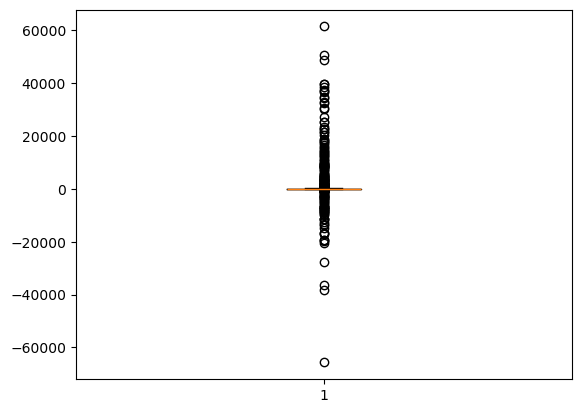

In [91]:
plt.boxplot(test_residus)

c:\Users\syos\AppData\Local\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning:

use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.



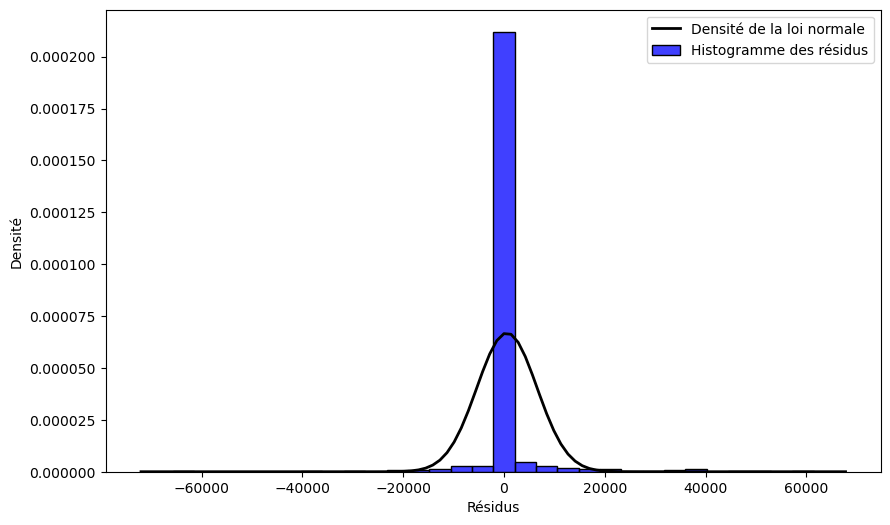

In [92]:
from scipy.stats import norm
from scipy import stats

# residus = y_test - y_pred_xgb
mu, std = norm.fit(test_residus)

# # fig,axes = plt.subplots(nrows = 1 ,ncols=2, figsize=(8, 3))

# # axes[0].hist(residus)
# # axes[0].set_xlabel("Résidus")
# # axes[0].set_title("Distribution des résidus")

# # axes[1].hist(y_test)
# # axes[1].set_xlabel("Consommation d'énergie")
# # axes[1].set_title("Distribution de la consommation d'énergie")


plt.figure(figsize=(10, 6))
sns.histplot(test_residus, bins=30, kde=False, color='blue', stat='density', label='Histogramme des résidus')

# Tracer la densité de la loi normale
xmin, xmax = plt.xlim()
x = np.linspace(xmin, xmax, 100)
p = norm.pdf(x, mu, std)
plt.plot(x, p, 'k', linewidth=2, label='Densité de la loi normale')

# Ajouter des labels et une légende
plt.xlabel('Résidus')
plt.ylabel('Densité')
plt.legend()

# Afficher le graphique
plt.show()

# plt.figure(figsize=(12, 6))
# plt.hist(train_residus, bins=20, alpha=0.5, label='Training data residuals', color='blue')
# plt.hist(test_residus, bins=20, alpha=0.5, label='Test data residuals', color='lightgreen')
# plt.xlabel('Residuals')
# plt.ylabel('Frequency')
# plt.title('Distribution of Residuals')
# plt.legend()
# plt.show()

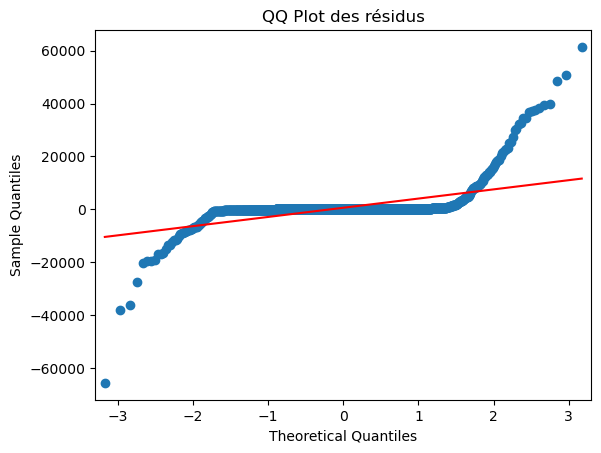

In [93]:
sm.qqplot(test_residus,line='r')
plt.title('QQ Plot des résidus')
plt.show()

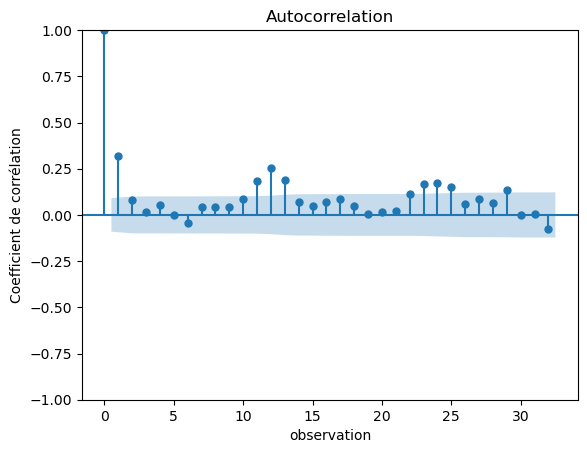

In [94]:
from statsmodels.graphics.tsaplots import plot_acf

plot_acf(test_residus,alpha=0.001)
plt.xlabel("observation")
plt.ylabel("Coefficient de corrélation")
plt.show()

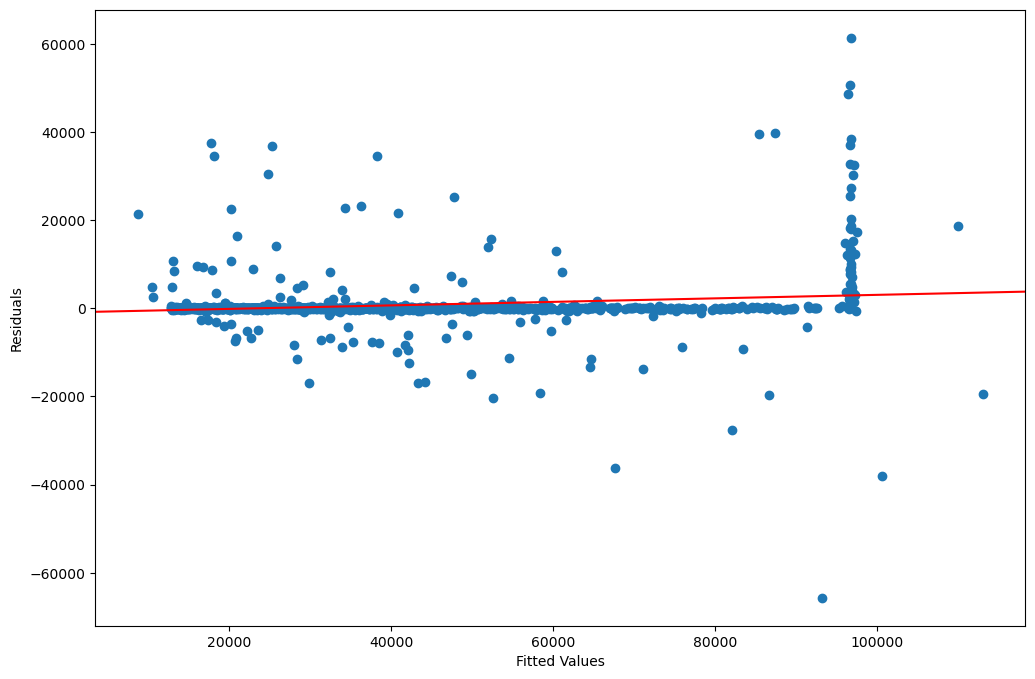

In [95]:
fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot(111, ylabel="Residuals", xlabel="Fitted Values")
ax.scatter(reel_et_pred["Pred"], test_residus)
y_vs_yhat = sm.OLS(test_residus, sm.add_constant(reel_et_pred["Pred"], prepend=True)).fit()
fig = abline_plot(model_results=y_vs_yhat, ax=ax, color="red")


# Modèlisation du prix

In [96]:
variables_a_garder_prix = variables_a_garder + ["Energie_totale"]
preprocessor_prix = ColumnTransformer(
    transformers=[
        ('cat', OneHotEncoder(handle_unknown='ignore'), new_variables_cat),
        ('num', 'passthrough', [item for item in variables_a_garder_prix if item not in var_a_supp])
    ])

In [97]:
test_donnees_modele_cout = test_donnees_modele
test_donnees_modele_cout["Energie_totale"] = test["Energie_totale"]
test_donnees_modele_cout["Energie_totale"] = test_donnees_modele_cout["Energie_totale"]#.apply(lambda x : np.sqrt(x))
test_donnees_modele_cout["Depenses_totales"] = test["Depenses_totales"]
test_donnees_modele_cout = test_donnees_modele_cout.loc[test_donnees_modele_cout["Depenses_totales"]>1864]

df_augmented_cout = augmente_donnees(test_donnees_modele_cout,categorical_vars)
#df_augmented_cout = test_donnees_modele_cout.copy()

y_cout = df_augmented_cout["Depenses_totales"].apply(lambda x : np.sqrt(x))
df_augmented_cout = df_augmented_cout[df_augmented_cout.columns[:-1]]


X_train_cout, X_test_cout, y_train_cout, y_test_cout = train_test_split(df_augmented_cout, y_cout, test_size=0.25, random_state=57)
#X_train_cout,X_test_cout,y_train_cout,y_test_cout= df_augmented_cout[df_augmented_cout['Année'] < 2023], df_augmented_cout[df_augmented_cout['Année'] >= 2023], y_cout[df_augmented_cout['Année'] < 2023], y_cout[df_augmented_cout['Année'] >= 2023]

# X = df_augmented_cout.iloc[:,:-1]
# X_train_cout,X_test_cout,y_train_cout,y_test_cout= X[df_augmented_cout['Année'] < 2023], X[df_augmented_cout['Année'] >= 2023], y_cout[df_augmented_cout['Année'] < 2023], y_cout[df_augmented_cout['Année'] >= 2023]

# df_train_augmented_cout = augmente_donnees(df_augmented_cout[df_augmented_cout['Année'] < 2023], categorical_vars)

# X_train_cout = df_train_augmented_cout.drop(columns=['Depenses_totales'])
# y_train_cout = df_train_augmented_cout['Depenses_totales'].apply(lambda x: np.sqrt(x))

annual_data_test_cout = pd.concat([X_test_cout, pd.Series(y_test_cout**2,name="Depenses_totales")],axis=1)
annual_data_test_cout = annual_data_test_cout[["Année","Depenses_totales"]].groupby(by="Année",as_index=False).sum()

In [98]:
q_low_cout = y_test_cout.quantile(0.01)
q_high_cout = y_test_cout.quantile(0.99)

y_test_cout = y_test_cout.clip(lower=q_low_cout, upper=q_high_cout)
y_train_cout = y_train_cout.clip(lower=q_low_cout, upper=q_high_cout)

In [99]:
# def xgb_objective_cout(trial):
#     n_estimators = trial.suggest_int('n_estimators', 10, 500)
#     max_depth = trial.suggest_int('max_depth', 1, 100)
#     learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1)
#     gamma = trial.suggest_float('gamma', 0, 1,step=0.01)
#     subsample = trial.suggest_float('subsample', 0.5, 1,step=0.01)
#     reg_alpha = trial.suggest_float('reg_alpha', 0, 1,step=0.01)
#     reg_lambda = trial.suggest_float('reg_lambda', 0, 1,step=0.01)
    
    
#     model = Pipeline(steps=[
#     ('preprocessor', preprocessor_prix),
#     ('regressor', xgb.XGBRegressor(objective='reg:squarederror',n_estimators=n_estimators, max_depth=max_depth, learning_rate=learning_rate, random_state=42, verbosity=0,
#                              gamma=gamma, subsample=subsample,reg_alpha = reg_alpha, reg_lambda = reg_lambda))
# ])
    
#     model.fit(X_train_cout, y_train_cout)
#     y_pred = model.predict(X_test_cout)
    
#     annual_data_pred = pd.concat([X_test_cout.reset_index(drop=True), pd.Series(y_pred**2,name="Depenses_totales")],axis=1)
#     annual_data_pred = annual_data_pred[["Année","Depenses_totales"]].groupby(by="Année",as_index=False).sum()
    
#     return mean_squared_error(annual_data_test_cout["Depenses_totales"], annual_data_pred["Depenses_totales"])


# xgb_study_cout = optuna.create_study(direction='minimize')
# xgb_study_cout.optimize(xgb_objective_cout, n_trials=100)

In [100]:
#xgb_study_cout.best_params

In [101]:
# Entraînement du modèle
#best_xgb_cout_params = xgb_study_cout.best_params
best_xgb_cout_params = {'n_estimators': 429,'max_depth': 79,'learning_rate': 0.9815310494351788,'gamma': 0.99,'subsample': 0.79,'reg_alpha': 0.74,'reg_lambda': 0.11}

model = Pipeline(steps=[
        ('preprocessor',preprocessor_prix),
        ('regressor',xgb.XGBRegressor(objective='reg:squarederror', n_estimators=best_xgb_cout_params['n_estimators'], max_depth=best_xgb_cout_params['max_depth'], 
                              learning_rate=best_xgb_cout_params['learning_rate'], verbosity=0,
                              gamma=best_xgb_cout_params['gamma'], subsample=best_xgb_cout_params['subsample'],
                              reg_alpha=best_xgb_cout_params['reg_alpha'], reg_lambda=best_xgb_cout_params['reg_lambda'],
                              random_state=42) )
])

model.fit(X_train_cout, y_train_cout)

R_squared_cout_train = r2_score(y_train_cout,model.predict(X_train_cout))

# Évaluation du modèle
y_pred_cout = model.predict(X_test_cout)
annual_data_pred_cout = pd.concat([X_test_cout.reset_index(drop=True), pd.Series(y_pred_cout**2,name="Depenses_totales")],axis=1)
annual_data_pred_cout = annual_data_pred_cout[["Année","Depenses_totales"]].groupby(by="Année",as_index=False).sum()

mse_cout = mean_squared_error(annual_data_test_cout["Depenses_totales"], annual_data_pred_cout["Depenses_totales"])
rmse_cout = np.sqrt(mse_cout)
mae_cout = mean_absolute_error(annual_data_test_cout["Depenses_totales"], annual_data_pred_cout["Depenses_totales"]) 

print(f'R2: {R_squared_cout_train}')
print(f'RMSE: {rmse_cout}')
print(f'MAE: {mae_cout}')

R2: 0.9993830647931198
RMSE: 2309.7925401051434
MAE: 2025.5270343555796


In [102]:
annual_data_test_cout["Depenses_totales"].describe()

count    6.000000e+00
mean     9.329389e+05
std      2.892491e+05
min      6.495454e+05
25%      7.346938e+05
50%      8.451236e+05
75%      1.074678e+06
max      1.408760e+06
Name: Depenses_totales, dtype: float64

In [103]:
reel_et_pred_cout = pd.DataFrame({
    "Année": test_donnees_modele_cout["Année"], "Reel": test_donnees_modele_cout["Depenses_totales"], "Pred":model.predict(test_donnees_modele_cout.drop(columns=["Depenses_totales"]))**2
})
reel_et_pred_cout_group = reel_et_pred_cout.groupby(by="Année",as_index=False).sum()


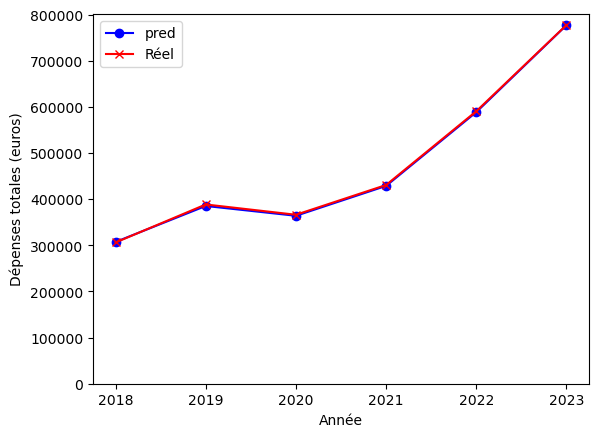

In [104]:
plt.figure()

plt.plot(reel_et_pred_cout_group["Année"], reel_et_pred_cout_group["Pred"], label='pred', color='blue', marker='o')
plt.plot(reel_et_pred_cout_group["Année"], reel_et_pred_cout_group["Reel"], label='Réel', color='red', marker='x')

plt.ylim(0, )

plt.xlabel("Année")
plt.ylabel("Dépenses totales (euros)")
plt.legend()
plt.show()

# Prévision

In [ ]:
data_prevision = pd.read_excel("path/Donnees_prevision_sans_changement_horizon_2040.xlsx",sheet_name="Feuil1",header=2)
data_prevision_change = pd.read_excel("path/Donnees_prevision_avec_changement_horizon_2040.xlsx",sheet_name="Feuil1",header=2)

In [106]:
data_prevision = data_prevision.loc[data_prevision["Nom_etablissement"]!= "Collège FERNAND PUECH" ].reset_index()
data_prevision_change = data_prevision_change.loc[data_prevision_change["Nom_etablissement"]!= "Collège FERNAND PUECH" ].reset_index()

data_prevision["Realisation_audit_energetique"] = data_prevision["Année de réalisation d'un audit énergétique"].apply(lambda x: "non" if x is None else "oui")
data_prevision_change["Realisation_audit_energetique"] = data_prevision_change["Année de réalisation d'un audit énergétique"].apply(lambda x: "oui")

renov=[]
for i in range(len(data_prevision)):
    if data_prevision['Année de construction la plus ancienne'].iloc[i]==data_prevision['Année de construction la plus récente'].iloc[i]:
        renov+=[0]
    else:
        renov+=[1]

data_prevision["Renovation"] = renov
data_prevision_change["Renovation"] = np.repeat(1, len(renov))

data_prevision = data_prevision.drop(columns=['Année de construction la plus ancienne','Année de construction la plus récente'])
data_prevision_change = data_prevision_change.drop(columns=['Année de construction la plus ancienne','Année de construction la plus récente'])

l = []
control_list=[]
s = list(data_prevision["Puissange_total_chaudiere"])
for i in range(len(s)):
    num = str(s[i]).split(" ")[0].split("K")[0] ## Sélectionne la valeur sans unité
    control_list += [num]
for puissance in control_list: ## boucle pour traiter les puissances données comme: 100/300
    if len(str(puissance).split("/"))==2:
        num = puissance.split("/")[1] ## ou .split("/")[0] pour prendre la valeur min
    else:
        num = puissance.split("/")[0]    
    l+=[float(num)]

data_prevision["Puissange_total_chaudiere"] = l
data_prevision_change["Puissange_total_chaudiere"] = l


data_prevision_change["Surface chauffée"] = data_prevision_change["Surface chauffée"].apply(lambda x: x-0.1*x)


In [107]:
data_prevision[['Nombre_chaudiere', 'Puissange_total_chaudiere']] = data_prevision[['Nombre_chaudiere', 'Puissange_total_chaudiere']].fillna(0)


data_prevision_change[['Nombre_chaudiere', 'Puissange_total_chaudiere']] = data_prevision_change[['Nombre_chaudiere', 'Puissange_total_chaudiere']].fillna(0)


In [108]:
last_nbre_eleves = test.groupby('Nom_etablissement')['Nombre_d_eleves'].last().to_dict()

In [109]:
liste_annees = list(data_prevision["Année"].unique())
for year in liste_annees:
    for etablissement in data_prevision["Nom_etablissement"].unique():
        # Filtrer les données pour l'établissement et l'année actuels
        data_etablissement_annee = data_prevision[(data_prevision["Année"] == year) & (data_prevision["Nom_etablissement"] == etablissement)]
        
        # Obtenir le dernier nombre d'élèves pour l'établissement
        dernier_nombre_eleves = last_nbre_eleves[etablissement]
        
        for idx, row in data_etablissement_annee.iterrows():
            if (row['Nombre_d_eleves'] / row['Capacite_accueil']) >= 1:
                nouveau_nbre_eleves = dernier_nombre_eleves * (1 - (0.1 / 100))
            else:
                nouveau_nbre_eleves = dernier_nombre_eleves * (1 + (0.1 / 100))
            
            # Arrondir le nouveau nombre d'élèves
            nouveau_nbre_eleves_arrondi = np.ceil(nouveau_nbre_eleves)
            
            # Mettre à jour la valeur dans le DataFrame
            data_prevision.loc[idx, 'Nombre_d_eleves'] = nouveau_nbre_eleves_arrondi.astype(float)
            data_prevision_change.loc[idx, 'Nombre_d_eleves'] = nouveau_nbre_eleves_arrondi.astype(float)
            
            # Mettre à jour le dernier nombre d'élèves pour l'établissement
            last_nbre_eleves[etablissement] = nouveau_nbre_eleves_arrondi

In [110]:
last_values = test.groupby('Nom_etablissement')['Energie_totale'].last().to_dict()

In [111]:
variables_a_garder_prevision = [var for var in variables_a_garder if var not in [
    'Energie Finale Fact - Gaz propane (kWhEF Fact)',
    'Energie Finale Fact - Fioul domestique (kWhEF Fact)',
    'Energie Finale Fact - Gaz naturel (kWhEF Fact)',
    'Energie Finale Fact - Chauffage urbain (kWhEF Fact)',
    'Energie Finale Fact - Bois plaquettes forestières (kWhEF Fact)',
    'Energie Finale Fact - Electrique (kWhEF Fact)'
]]

data_prevision_modele = data_prevision[variables_a_garder_prevision]

# data_prevision_modele['Année_squared'] = data_prevision_modele["Année"].apply(lambda x : x**2)
# data_prevision_modele["Lag_conso"] = data_prevision['Nom_etablissement'].map(last_values)
# data_prevision_modele["Nombre_annee_ecoule"] = data_prevision_modele['Année'].apply(lambda x : x-2018)

#data_prevision_modele['Consommation - Eau'] =  np.sqrt(data_prevision_modele['Consommation - Eau'])
#data_prevision_modele["Consommation - Eau"] = pd.cut(data_prevision_modele["Consommation - Eau"], bins=quantiles, labels=['Très faible', 'Faible', 'Moyenne', 'Élevée'],include_lowest=True)
#data_prevision_modele = sm.add_constant(data_prevision_modele)


data_prevision_change_modele = data_prevision_change[variables_a_garder_prevision]

#data_prevision_modele['Consommation - Eau'] =  np.sqrt(data_prevision_modele['Consommation - Eau'])
#data_prevision_change_modele["Consommation - Eau"] = pd.cut(data_prevision_change_modele["Consommation - Eau"], bins=quantiles, labels=['Très faible', 'Faible', 'Moyenne', 'Élevée'],include_lowest=True)

Ajouter la prévision de la consommation annuelle en 2024, ... , 2030

In [112]:
# #data_prevision_modele["Lag_conso"] = float('nan')
# print(len(data_prevision_modele))
# pred_conso2024 = []
# #lag_conso = [premier_college_a_predire["Energie_totale"][0]]
# for i in range(len(data_prevision_modele)):
#     #data_prevision_modele.loc[i, "Lag_conso"] = lag_conso[-1]
#     etablissement = data_prevision.loc[i, 'Nom_etablissement']
#     data_prevision_modele.loc[i, 'Lag_conso'] = last_values[etablissement]
#     #print(data_prevision_modele.iloc[i])
#     prediction = modele_xgb.predict(data_prevision_modele.iloc[i].to_frame().T) **2
#     pred_conso2024.append(prediction[0])
#     #lag_conso.append(prediction[0])
#     last_values[etablissement] = pred_conso2024[i]
    
# print(f'Data: {len(data_prevision_modele)} ; Pred: {len(pred_conso2024)} ; Lag: {len(lag_conso)}')

In [113]:
#data_prevision_modele["Lag_conso"] = lag_conso[:len(data_prevision_modele)]
data_prevision_modele["Energie_totale"] = modele_xgb.predict(data_prevision_modele) **2
data_prevision_change_modele["Energie_totale"] = modele_xgb.predict(data_prevision_change_modele) **2

data_prevision_modele["Depenses_totales"] = model.predict(data_prevision_modele)**2
data_prevision_change_modele["Depenses_totales"] = model.predict(data_prevision_change_modele)**2

# pred_depenses2024 = model.predict(data_prevision_modele) ** 2
# data_prevision_modele["Depenses_totales"] = pred_depenses2024

annual_pred_2024_2040 = data_prevision_modele[["Année","Energie_totale","Depenses_totales"]].groupby(by="Année",as_index=False).sum()
annual_pred_2024_2040_change = data_prevision_change_modele[["Année","Energie_totale","Depenses_totales"]].groupby(by="Année",as_index=False).sum()

C:\Users\syos\AppData\Local\Temp\ipykernel_1688\3594371699.py:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\syos\AppData\Local\Temp\ipykernel_1688\3594371699.py:3: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\syos\AppData\Local\Temp\ipykernel_1688\3594371699.py:5: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs

In [114]:
annual_data = test[["Année","Energie_totale","Depenses_totales"]].groupby(by="Année",as_index=False).sum()

In [115]:
haha = pd.concat([annual_data,annual_pred_2024_2040])

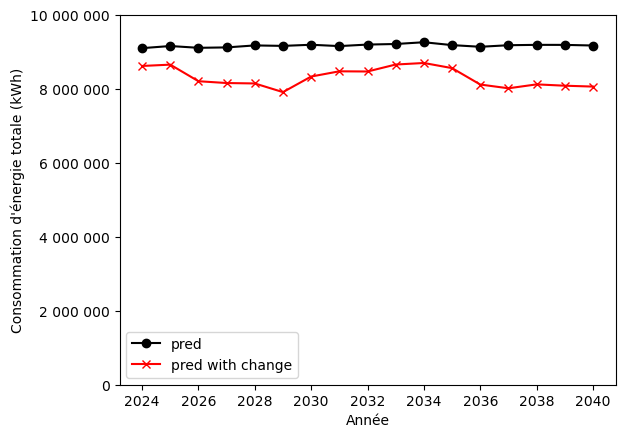

In [116]:
plt.figure()

plt.plot(annual_pred_2024_2040["Année"], annual_pred_2024_2040["Energie_totale"], label='pred', color='black', marker='o')
plt.plot(annual_pred_2024_2040_change["Année"], annual_pred_2024_2040_change["Energie_totale"], label='pred with change', color='red', marker='x')
#plt.plot(annual_data["Année"], annual_data["Energie_totale"], label='2018 à 2023', color='green', marker='o')

plt.ylim(00000,10000000)
plt.gca().get_yaxis().set_major_formatter(FuncFormatter(millions))

plt.xlabel("Année")
plt.ylabel("Consommation d'énergie totale (kWh)")
plt.legend()
plt.show()

In [117]:
mean_absolute_error(annual_pred_2024_2040["Energie_totale"],annual_pred_2024_2040_change["Energie_totale"])

859710.5

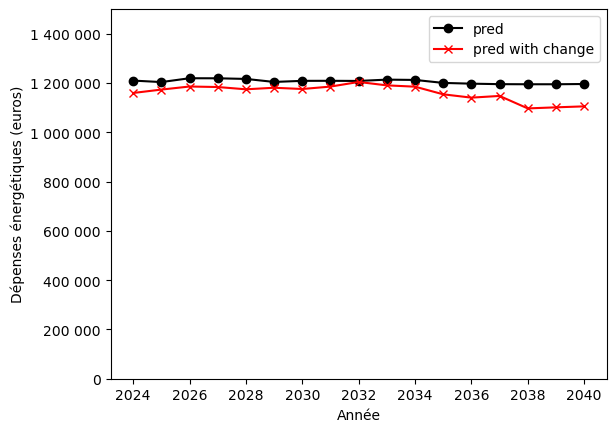

In [118]:
plt.figure()

plt.plot(annual_pred_2024_2040["Année"], annual_pred_2024_2040["Depenses_totales"], label='pred', color='black', marker='o')
plt.plot(annual_pred_2024_2040_change["Année"], annual_pred_2024_2040_change["Depenses_totales"], label='pred with change', color='red', marker='x')
#plt.plot(annual_data["Année"], annual_data["Depenses_totales"], label='2018 à 2023', color='green', marker='o')

plt.ylim(00000, 1500000 )
plt.gca().get_yaxis().set_major_formatter(FuncFormatter(millions))

plt.xlabel("Année")
plt.ylabel("Dépenses énergétiques (euros)")
plt.legend()
plt.show()

In [119]:
mean_absolute_error(annual_pred_2024_2040["Depenses_totales"],annual_pred_2024_2040_change["Depenses_totales"])

44703.516